# Sparse Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the sparse dataset. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Sparse Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. Bellow the dataset for maximum voltage constraints is shown.

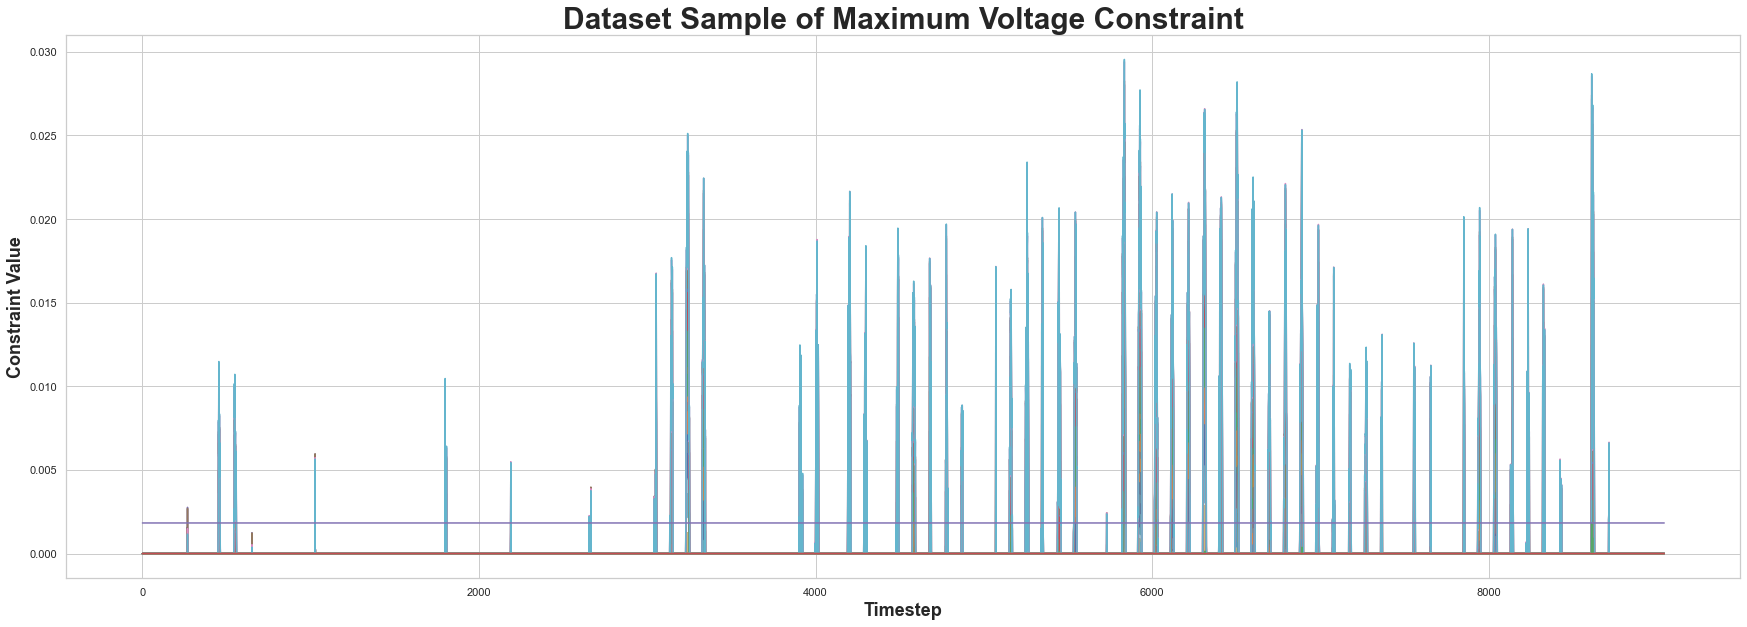

In [1]:
import sys; sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data, y_max_u)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

The sparse boolean dataset is derived from the one above. It represents the time steps with constraints as of the class 1 and the rest as class 0. This datset is used to train the classification models.

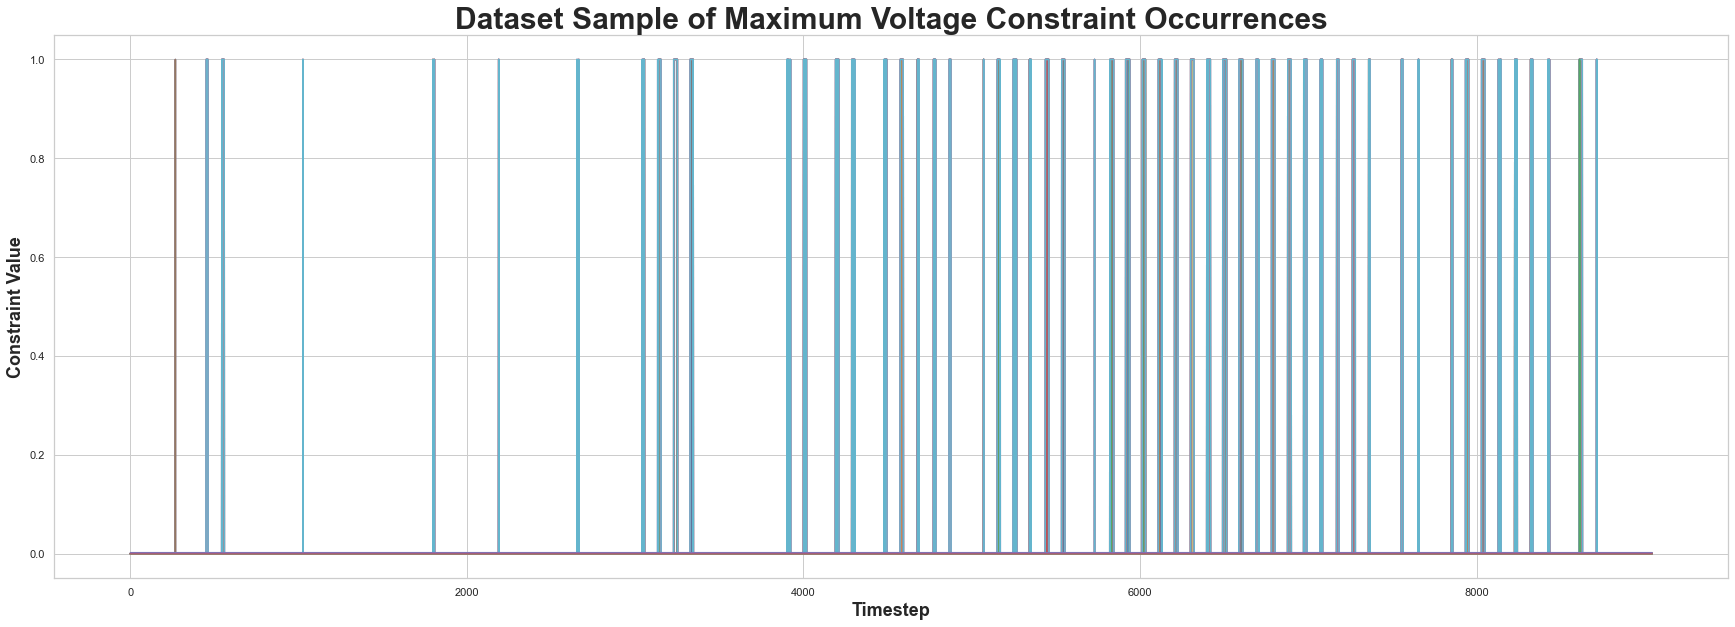

In [2]:
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps')
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_sparse_bool_train, X_max_u_sparse_bool_test, y_max_u_sparse_bool_train, y_max_u_sparse_bool_test = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool)
data = {'X_train': X_max_u_sparse_bool_train,
        'X_test': X_max_u_sparse_bool_test,
        'y_train': utils.convert_df_to_bool(y_max_u_sparse_bool_train),
        'y_test': utils.convert_df_to_bool(y_max_u_sparse_bool_test)}
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_sparse_bool_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint Occurrences', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

However, not all busses have constraints, so it is only possible train classification models for those busses that have positive values in the target dataset.

In [3]:
utils.cols_with_positive_values(y_max_u_sparse_bool)

['bus_8',
 'bus_9',
 'bus_10',
 'bus_11',
 'bus_12',
 'bus_13',
 'bus_14',
 'bus_15',
 'bus_16',
 'bus_18',
 'bus_32']

## Import Libraries

In [4]:
import optuna 
import os

import numpy as np
import pandas as pd 
import sklearn.metrics
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [5]:
# General parameters
num_trials = 30

In [6]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) / scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) / scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.0644069763149719
0.05260425830867303


In [7]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) / scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) / scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.0644069763149719
0.05260425830867303


### Extreme Gradient Boosting Regressor

In [8]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-14 22:19:48,062] A new study created in memory with name: no-name-bd2de5e9-4c63-47bf-96ce-ee8cff43af33
[I 2022-10-14 22:30:34,044] Trial 0 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0015378139424258182, 'alpha': 0.12354594688360422, 'subsample': 0.9744749809753406, 'colsample_bytree': 0.8214684533278218, 'max_depth': 9, 'min_child_weight': 7, 'eta': 3.845447094886408e-08, 'gamma': 1.5661122113618665e-07, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.8990882238497667e-08, 'skip_drop': 0.42042800643668815}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 22:31:53,229] Trial 1 finished with value: 0.3297252223489261 and parameters: {'booster': 'gblinear', 'lambda': 1.2136009779074137e-05, 'alpha': 1.0301985701440252e-05, 'subsample': 0.20917337579701423, 'colsample_bytree': 0.25040659741822024}. Best is trial 1 with value: 0.3297252223489261.


true_positives_ctr:  2918
true_negatives_ctr:  297849
false_positives_ctr:  4698
false_negatives_ctr:  2031
3419674282254666240


[I 2022-10-14 22:33:10,130] Trial 2 finished with value: -1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.013092923074299033, 'alpha': 0.028082332597870574, 'subsample': 0.9470659826973344, 'colsample_bytree': 0.4686514059011148}. Best is trial 1 with value: 0.3297252223489261.


true_positives_ctr:  0
true_negatives_ctr:  302547
false_positives_ctr:  0
false_negatives_ctr:  4949
0


[I 2022-10-14 22:42:32,464] Trial 3 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 6.774861313236246e-05, 'alpha': 3.897015129380217e-06, 'subsample': 0.7724921943594174, 'colsample_bytree': 0.40656068713739907, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.0026735771776969074, 'gamma': 0.015332065724378702, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.0502426413139034e-07, 'skip_drop': 0.0004425108211405524}. Best is trial 1 with value: 0.3297252223489261.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 22:49:07,652] Trial 4 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 6.219820982455833e-07, 'alpha': 0.02107796640435248, 'subsample': 0.33448710059232123, 'colsample_bytree': 0.7514407348127758, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.005354313730091847, 'gamma': 0.003060357157452301, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00018118764729328744, 'skip_drop': 2.4837235918254455e-05}. Best is trial 1 with value: 0.3297252223489261.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 22:50:05,614] Trial 5 finished with value: 0.33153250528616784 and parameters: {'booster': 'gblinear', 'lambda': 0.012813062866693065, 'alpha': 4.592403334094441e-05, 'subsample': 0.24164543492837423, 'colsample_bytree': 0.4052974747317044}. Best is trial 5 with value: 0.33153250528616784.


true_positives_ctr:  2975
true_negatives_ctr:  297640
false_positives_ctr:  4907
false_negatives_ctr:  1974
3535972167648567444


[I 2022-10-14 22:50:58,388] Trial 6 finished with value: 0.32582464303057035 and parameters: {'booster': 'gblinear', 'lambda': 0.0004113163074734939, 'alpha': 2.3350055755830917e-07, 'subsample': 0.7946694660815099, 'colsample_bytree': 0.9189585275981551}. Best is trial 5 with value: 0.33153250528616784.


true_positives_ctr:  2916
true_negatives_ctr:  297711
false_positives_ctr:  4836
false_negatives_ctr:  2033
3479161327592235264


[I 2022-10-14 22:57:58,966] Trial 7 finished with value: 0.42999054621069244 and parameters: {'booster': 'dart', 'lambda': 0.0454767348158262, 'alpha': 3.207842599868991e-08, 'subsample': 0.9493969916395724, 'colsample_bytree': 0.5508018869962596, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.07061308139813241, 'gamma': 2.749012234014751e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.015200267124244273, 'skip_drop': 0.024808675522989813}. Best is trial 7 with value: 0.42999054621069244.


true_positives_ctr:  3213
true_negatives_ctr:  299043
false_positives_ctr:  3504
false_negatives_ctr:  1736
3025054226390866929


[I 2022-10-14 22:58:52,610] Trial 8 finished with value: -1.0 and parameters: {'booster': 'gblinear', 'lambda': 2.4896203835319254e-08, 'alpha': 0.42848130158808473, 'subsample': 0.5122899330218491, 'colsample_bytree': 0.2646591537123202}. Best is trial 7 with value: 0.42999054621069244.


true_positives_ctr:  0
true_negatives_ctr:  302547
false_positives_ctr:  0
false_negatives_ctr:  4949
0


[I 2022-10-14 23:04:55,032] Trial 9 finished with value: 0.41479778332121525 and parameters: {'booster': 'dart', 'lambda': 6.274608842795379e-05, 'alpha': 1.0977531104790303e-07, 'subsample': 0.9381608661035263, 'colsample_bytree': 0.8797104707544374, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.02499188528324322, 'gamma': 0.0003971526966688059, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.35360343298744934, 'skip_drop': 0.0012829880892794468}. Best is trial 7 with value: 0.42999054621069244.


true_positives_ctr:  4300
true_negatives_ctr:  292600
false_positives_ctr:  9947
false_negatives_ctr:  649
6255618694460020809


[I 2022-10-14 23:06:34,858] Trial 10 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.5554817595183809, 'alpha': 1.2121146737884116e-08, 'subsample': 0.5922908148225485, 'colsample_bytree': 0.6389906323188058, 'max_depth': 5, 'min_child_weight': 10, 'eta': 1.1791922127161658e-05, 'gamma': 5.2452276978870576e-08, 'grow_policy': 'depthwise'}. Best is trial 7 with value: 0.42999054621069244.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 23:12:33,772] Trial 11 finished with value: 0.4319496946659871 and parameters: {'booster': 'dart', 'lambda': 0.9344171839520812, 'alpha': 1.3689057189900412e-08, 'subsample': 0.8096935330309921, 'colsample_bytree': 0.9828031582410937, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.455005459910248, 'gamma': 1.9870442248730487e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.28199246538572786, 'skip_drop': 0.01497201065208554}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  2967
true_negatives_ctr:  300015
false_positives_ctr:  2532
false_negatives_ctr:  1982
2486546888899609809


[I 2022-10-14 23:19:06,212] Trial 12 finished with value: 0.39359961557891243 and parameters: {'booster': 'dart', 'lambda': 0.6710574347400968, 'alpha': 1.1109879879787984e-08, 'subsample': 0.7748408502867212, 'colsample_bytree': 0.9938880353277538, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.5482063273081084, 'gamma': 4.5901795801648e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.3265689467021904, 'skip_drop': 0.21041099915268738}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  2780
true_negatives_ctr:  299825
false_positives_ctr:  2722
false_negatives_ctr:  2169
2487878719329151764


[I 2022-10-14 23:21:05,178] Trial 13 finished with value: 0.2001355229574099 and parameters: {'booster': 'gbtree', 'lambda': 0.08746454328957722, 'alpha': 0.0011975281645773598, 'subsample': 0.8453862480413313, 'colsample_bytree': 0.6182778289604991, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.8525698575069415, 'gamma': 7.494127794789551e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  2725
true_negatives_ctr:  289600
false_positives_ctr:  12947
false_negatives_ctr:  2224
6847873572930009984


[I 2022-10-14 23:28:23,130] Trial 14 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.03146277807739183, 'alpha': 4.4233331289014614e-07, 'subsample': 0.6748733989064352, 'colsample_bytree': 0.7196086440306917, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.00029191942329231225, 'gamma': 3.4368432027844767e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.005669216005328617, 'skip_drop': 8.671591024168146e-08}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 23:35:08,507] Trial 15 finished with value: 0.3817937447448211 and parameters: {'booster': 'dart', 'lambda': 0.18264189921158033, 'alpha': 1.6753906015723556e-06, 'subsample': 0.8706385449249777, 'colsample_bytree': 0.5153979925217271, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.044710826662325814, 'gamma': 0.5026276926356853, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0075725317541915985, 'skip_drop': 0.013176696914135685}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  3174
true_negatives_ctr:  297901
false_positives_ctr:  4646
false_negatives_ctr:  1775
3508884079644630960


[I 2022-10-14 23:42:01,638] Trial 16 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.002329691040821723, 'alpha': 4.9879684497092785e-08, 'subsample': 0.6766828032622091, 'colsample_bytree': 0.559754826120006, 'max_depth': 7, 'min_child_weight': 8, 'eta': 5.382666019198052e-06, 'gamma': 1.3178145994627155e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.006438563906986105, 'skip_drop': 0.021992353044990403}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 23:43:40,083] Trial 17 finished with value: 0.2312851078392276 and parameters: {'booster': 'gbtree', 'lambda': 0.7810785456139233, 'alpha': 0.0007163032858644413, 'subsample': 0.46977345373876167, 'colsample_bytree': 0.6843667969858722, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.17951206376102977, 'gamma': 1.0328571401510724e-06, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  3127
true_negatives_ctr:  288216
false_positives_ctr:  14331
false_negatives_ctr:  1822
7581579539765010612


[I 2022-10-14 23:46:44,163] Trial 18 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.003216046276662628, 'alpha': 5.430570342584898e-07, 'subsample': 0.9959995742337189, 'colsample_bytree': 0.7844710536279402, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.000348494460601897, 'gamma': 8.995125695092035e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.8092265245747018, 'skip_drop': 2.0826142495746228e-05}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 23:53:04,065] Trial 19 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.05773876410147188, 'alpha': 2.9902720272562997e-05, 'subsample': 0.8897792131010823, 'colsample_bytree': 0.3480946326834991, 'max_depth': 3, 'min_child_weight': 4, 'eta': 0.008664183190287871, 'gamma': 6.427799334401218e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00013071113309446345, 'skip_drop': 0.010895144399452336}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-14 23:55:43,056] Trial 20 finished with value: 0.3759100205410548 and parameters: {'booster': 'gbtree', 'lambda': 2.6400589642243224e-06, 'alpha': 0.00044812983154005504, 'subsample': 0.6849897821558832, 'colsample_bytree': 0.9932789830690089, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.10544711252053313, 'gamma': 3.961795108273589e-07, 'grow_policy': 'lossguide'}. Best is trial 11 with value: 0.4319496946659871.


true_positives_ctr:  2767
true_negatives_ctr:  299408
false_positives_ctr:  3139
false_negatives_ctr:  2182
2666985684957325620


[I 2022-10-15 00:02:55,989] Trial 21 finished with value: 0.48580657549480477 and parameters: {'booster': 'dart', 'lambda': 8.316891803820054e-05, 'alpha': 7.25517074234834e-08, 'subsample': 0.9098516719447127, 'colsample_bytree': 0.8878567572540867, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.02799504694621383, 'gamma': 0.0027540923731308336, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.08731145352551377, 'skip_drop': 0.0006685420870794137}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  3850
true_negatives_ctr:  298081
false_positives_ctr:  4466
false_negatives_ctr:  1099
3725266467790430640


[I 2022-10-15 00:10:06,103] Trial 22 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0003228048855530152, 'alpha': 5.39696631101454e-08, 'subsample': 0.8209629510553026, 'colsample_bytree': 0.8795811815726223, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.0016436942278978974, 'gamma': 0.006379231332075742, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.03232085499355553, 'skip_drop': 0.0012068513667454043}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-15 00:17:09,566] Trial 23 finished with value: 0.4528246994671496 and parameters: {'booster': 'dart', 'lambda': 2.1140324744181654e-07, 'alpha': 3.021981394038806e-08, 'subsample': 0.8863005077154654, 'colsample_bytree': 0.9279783632441553, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.08161693129906762, 'gamma': 0.07335681412282274, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.05549031343239157, 'skip_drop': 0.04789915997530037}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  3027
true_negatives_ctr:  300181
false_positives_ctr:  2366
false_negatives_ctr:  1922
2439471580525967337


[I 2022-10-15 00:23:59,556] Trial 24 finished with value: 0.42558301840760765 and parameters: {'booster': 'dart', 'lambda': 1.114887650655972e-08, 'alpha': 2.1368393774146845e-06, 'subsample': 0.7367029898627867, 'colsample_bytree': 0.9391712485179021, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.900073587062005, 'gamma': 0.23727541449649486, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0669229929480381, 'skip_drop': 0.00011157588044228353}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  2834
true_negatives_ctr:  300253
false_positives_ctr:  2294
false_negatives_ctr:  2115
2321636102040659712


[I 2022-10-15 00:31:12,853] Trial 25 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 1.270216332096436e-07, 'alpha': 1.009451701773722e-08, 'subsample': 0.893263404551182, 'colsample_bytree': 0.8405111153949868, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.015219365254402793, 'gamma': 0.06568583642166437, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0011854266149427615, 'skip_drop': 0.9815171152743192}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-15 00:37:33,490] Trial 26 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 6.023258291115861e-06, 'alpha': 1.6850475336219774e-07, 'subsample': 0.6085789876321214, 'colsample_bytree': 0.9442290175838282, 'max_depth': 5, 'min_child_weight': 3, 'eta': 3.502874261352775e-05, 'gamma': 0.000836547070031816, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.10306083246639358, 'skip_drop': 0.003072966789324072}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-15 00:45:41,937] Trial 27 finished with value: 0.4024654266141403 and parameters: {'booster': 'dart', 'lambda': 1.6563545492844096e-07, 'alpha': 7.514242996988301e-07, 'subsample': 0.7284169642796408, 'colsample_bytree': 0.8178751542030562, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.1755170199683935, 'gamma': 0.039493815602506185, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.873572353162467e-06, 'skip_drop': 2.559571441357023e-06}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  2906
true_negatives_ctr:  299575
false_positives_ctr:  2972
false_negatives_ctr:  2043
2654588094532012212


[I 2022-10-15 00:48:06,748] Trial 28 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 2.3553010381000475e-05, 'alpha': 4.45953391467105e-08, 'subsample': 0.9038030169665345, 'colsample_bytree': 0.882005037038552, 'max_depth': 7, 'min_child_weight': 5, 'eta': 6.237118224101613e-07, 'gamma': 0.0008667326567283637, 'grow_policy': 'depthwise'}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0


[I 2022-10-15 00:55:51,086] Trial 29 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0005954942897793855, 'alpha': 1.1469849766934782e-05, 'subsample': 0.9864655532728606, 'colsample_bytree': 0.9971069268656765, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0010698572363539497, 'gamma': 1.6684289478331423e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0013363562305112914, 'skip_drop': 0.15004969909183574}. Best is trial 21 with value: 0.48580657549480477.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  302547
false_negatives_ctr:  0
0
Number of finished trials:  30
Best trial:
  Value: 0.48580657549480477
  Params: 
    booster: dart
    lambda: 8.316891803820054e-05
    alpha: 7.25517074234834e-08
    subsample: 0.9098516719447127
    colsample_bytree: 0.8878567572540867
    max_depth: 7
    min_child_weight: 5
    eta: 0.02799504694621383
    gamma: 0.0027540923731308336
    grow_policy: lossguide
    sample_type: weighted
    normalize_type: forest
    rate_drop: 0.08731145352551377
    skip_drop: 0.0006685420870794137


In [9]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 00:55:51,179] A new study created in memory with name: no-name-65c56f72-e089-48ba-bf93-f9cae393d562
[I 2022-10-15 00:57:39,819] Trial 0 finished with value: 0.42233437416515685 and parameters: {'booster': 'gbtree', 'lambda': 3.824092272508583e-05, 'alpha': 0.001008214024372864, 'subsample': 0.6430146841084207, 'colsample_bytree': 0.29578898802547543, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.6193313175295313, 'gamma': 0.002505949906522586, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  4513
true_negatives_ctr:  293166
false_positives_ctr:  8308
false_negatives_ctr:  1509
6858921096032358900


[I 2022-10-15 00:58:41,210] Trial 1 finished with value: -1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.061691725987073266, 'alpha': 0.15139654075705425, 'subsample': 0.2890090840180496, 'colsample_bytree': 0.5466063456902068}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  0
true_negatives_ctr:  301474
false_positives_ctr:  0
false_negatives_ctr:  6022
0


[I 2022-10-15 01:06:00,990] Trial 2 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.00011718683930521697, 'alpha': 0.0022924267930722396, 'subsample': 0.3041853313576435, 'colsample_bytree': 0.7218059649202553, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.00038251029496457996, 'gamma': 0.001324538795614541, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3513272746305788e-08, 'skip_drop': 2.9281287815139385e-07}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:07:00,906] Trial 3 finished with value: -1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.001533079671725115, 'alpha': 0.05673005785335194, 'subsample': 0.9493385871022655, 'colsample_bytree': 0.4348891810648259}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  0
true_negatives_ctr:  301474
false_positives_ctr:  0
false_negatives_ctr:  6022
0


[I 2022-10-15 01:08:03,063] Trial 4 finished with value: 0.2815897230679974 and parameters: {'booster': 'gblinear', 'lambda': 5.547280906190784e-07, 'alpha': 6.681701377668611e-07, 'subsample': 0.6993297909407429, 'colsample_bytree': 0.9337772720304396}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  2528
true_negatives_ctr:  297049
false_positives_ctr:  4425
false_negatives_ctr:  3494
3793756574294109012


[I 2022-10-15 01:08:59,425] Trial 5 finished with value: 0.08643919328962234 and parameters: {'booster': 'gblinear', 'lambda': 0.43580768980439494, 'alpha': 0.00017444583826448307, 'subsample': 0.34810125874766407, 'colsample_bytree': 0.711818370631901}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  228
true_negatives_ctr:  301186
false_positives_ctr:  288
false_negatives_ctr:  5794
287574516195599040


[I 2022-10-15 01:11:01,631] Trial 6 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 5.919878682005678e-06, 'alpha': 1.2558452671347162e-07, 'subsample': 0.4220116353865582, 'colsample_bytree': 0.5678162391756081, 'max_depth': 7, 'min_child_weight': 8, 'eta': 4.355615400489945e-05, 'gamma': 0.30953975432296127, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:12:05,463] Trial 7 finished with value: 0.282360265275623 and parameters: {'booster': 'gblinear', 'lambda': 2.9444052946095004e-06, 'alpha': 1.2331205752559224e-08, 'subsample': 0.4871949497716518, 'colsample_bytree': 0.3053888514907837}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  2527
true_negatives_ctr:  297107
false_positives_ctr:  4367
false_negatives_ctr:  3495
3762302916875368464


[I 2022-10-15 01:14:18,839] Trial 8 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.000593123672567697, 'alpha': 0.00047718936635809175, 'subsample': 0.458655473019024, 'colsample_bytree': 0.7850989080930568, 'max_depth': 9, 'min_child_weight': 3, 'eta': 3.48289112741078e-06, 'gamma': 0.004160384685943608, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:15:21,935] Trial 9 finished with value: 0.28104255923519317 and parameters: {'booster': 'gblinear', 'lambda': 1.1827505212715027e-05, 'alpha': 8.603220695351679e-07, 'subsample': 0.7507596980061713, 'colsample_bytree': 0.30534902857082297}. Best is trial 0 with value: 0.42233437416515685.


true_positives_ctr:  2513
true_negatives_ctr:  297121
false_positives_ctr:  4353
false_negatives_ctr:  3509
3747371334921828240


[I 2022-10-15 01:16:48,706] Trial 10 finished with value: 0.42369096691591696 and parameters: {'booster': 'gbtree', 'lambda': 4.5176664469917356e-08, 'alpha': 3.0042596248416598e-05, 'subsample': 0.9523422235147552, 'colsample_bytree': 0.24850299252707217, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.9761070203375661, 'gamma': 6.248646119189918e-08, 'grow_policy': 'depthwise'}. Best is trial 10 with value: 0.42369096691591696.


true_positives_ctr:  4135
true_negatives_ctr:  295241
false_positives_ctr:  6233
false_negatives_ctr:  1887
5592798628864192512


[I 2022-10-15 01:18:15,378] Trial 11 finished with value: 0.44006841791442675 and parameters: {'booster': 'gbtree', 'lambda': 1.1090876620378933e-08, 'alpha': 1.1509367467116204e-05, 'subsample': 0.9742883835212691, 'colsample_bytree': 0.21290067176540578, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.8611265229217163, 'gamma': 1.3674508194127715e-08, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 0.44006841791442675.


true_positives_ctr:  4258
true_negatives_ctr:  295243
false_positives_ctr:  6231
false_negatives_ctr:  1764
5655765376953497044


[I 2022-10-15 01:19:42,261] Trial 12 finished with value: 0.4479749881671089 and parameters: {'booster': 'gbtree', 'lambda': 1.9197329070769883e-08, 'alpha': 1.0911963802710983e-05, 'subsample': 0.9780654456760052, 'colsample_bytree': 0.20280958722150255, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.8177623825427278, 'gamma': 1.3478961162718628e-08, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.4479749881671089.


true_positives_ctr:  4191
true_negatives_ctr:  295807
false_positives_ctr:  5667
false_negatives_ctr:  1831
5326817352993696912


[I 2022-10-15 01:21:13,332] Trial 13 finished with value: 0.2507493402632615 and parameters: {'booster': 'gbtree', 'lambda': 1.2676847445450998e-08, 'alpha': 8.990307100749094e-06, 'subsample': 0.8427986774312628, 'colsample_bytree': 0.20007876051343945, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.021188888823969205, 'gamma': 1.0504907252161922e-08, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.4479749881671089.


true_positives_ctr:  5934
true_negatives_ctr:  250367
false_positives_ctr:  51107
false_negatives_ctr:  88
25936265981259944340


[I 2022-10-15 01:27:57,120] Trial 14 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 2.314279758121744e-07, 'alpha': 6.183742193146362e-06, 'subsample': 0.9903016914255759, 'colsample_bytree': 0.4580326713071966, 'max_depth': 3, 'min_child_weight': 7, 'eta': 1.780111677950508e-08, 'gamma': 1.470695821597761e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.1438740077353264, 'skip_drop': 0.92640006580934}. Best is trial 12 with value: 0.4479749881671089.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:29:38,047] Trial 15 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 1.0644276508434641e-08, 'alpha': 0.011598939318997704, 'subsample': 0.8580822946421315, 'colsample_bytree': 0.4100996510456263, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.012997333067303416, 'gamma': 1.7403688277219785e-06, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.4479749881671089.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:31:18,372] Trial 16 finished with value: 0.26046878851240646 and parameters: {'booster': 'gbtree', 'lambda': 2.3598250856983884e-07, 'alpha': 3.5831507324434574e-05, 'subsample': 0.82281559587222, 'colsample_bytree': 0.35717136504194347, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.021053374933650382, 'gamma': 5.780230933745528e-07, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.4479749881671089.


true_positives_ctr:  5967
true_negatives_ctr:  252626
false_positives_ctr:  48848
false_negatives_ctr:  55
25145635727819598420


[I 2022-10-15 01:37:44,610] Trial 17 finished with value: 0.40268480981945787 and parameters: {'booster': 'dart', 'lambda': 9.9541716766163e-08, 'alpha': 3.782910277508142e-06, 'subsample': 0.5649532941072709, 'colsample_bytree': 0.21580902935448795, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.9107999919386254, 'gamma': 1.811564629835732e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.8769727519238572e-06, 'skip_drop': 0.015316139271013236}. Best is trial 12 with value: 0.4479749881671089.


true_positives_ctr:  3880
true_negatives_ctr:  295494
false_positives_ctr:  5980
false_negatives_ctr:  2142
5327862261344690880


[I 2022-10-15 01:39:41,330] Trial 18 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 1.1439776428602515e-06, 'alpha': 6.73675738213018e-08, 'subsample': 0.9071169968051309, 'colsample_bytree': 0.516659751064502, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.0014824897500721897, 'gamma': 1.0601480180422198e-08, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 0.4479749881671089.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:41:10,666] Trial 19 finished with value: 0.5095538528850857 and parameters: {'booster': 'gbtree', 'lambda': 3.7898370374522055e-08, 'alpha': 0.00010964886964206248, 'subsample': 0.21332117209758417, 'colsample_bytree': 0.9149700405271868, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.0499054023701774, 'gamma': 1.563555152736816e-07, 'grow_policy': 'depthwise'}. Best is trial 19 with value: 0.5095538528850857.


true_positives_ctr:  4998
true_negatives_ctr:  294505
false_positives_ctr:  6969
false_negatives_ctr:  1024
6420605843686360404


[I 2022-10-15 01:42:50,484] Trial 20 finished with value: 0.5228804466847852 and parameters: {'booster': 'gbtree', 'lambda': 0.0029736186442089643, 'alpha': 0.00020383385866706104, 'subsample': 0.21687989966826238, 'colsample_bytree': 0.9759542348849157, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0484664602510607, 'gamma': 1.8747614633455993e-05, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.5228804466847852.


true_positives_ctr:  4967
true_negatives_ctr:  295033
false_positives_ctr:  6441
false_negatives_ctr:  1055
6132265270872678912


[I 2022-10-15 01:44:29,909] Trial 21 finished with value: 0.5146229104371267 and parameters: {'booster': 'gbtree', 'lambda': 0.011782676551457118, 'alpha': 0.00019607824943779936, 'subsample': 0.2013090894510327, 'colsample_bytree': 0.9525559814487271, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.08184153719577579, 'gamma': 5.376277363499451e-05, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.5228804466847852.


true_positives_ctr:  4857
true_negatives_ctr:  295254
false_positives_ctr:  6220
false_negatives_ctr:  1165
5960995691887624564


[I 2022-10-15 01:46:07,782] Trial 22 finished with value: 0.5181553391181186 and parameters: {'booster': 'gbtree', 'lambda': 0.0036938228627853373, 'alpha': 0.005437746130927448, 'subsample': 0.2039506021204024, 'colsample_bytree': 0.9774362462547027, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.04643468446108407, 'gamma': 7.055118550076213e-05, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.5228804466847852.


true_positives_ctr:  5014
true_negatives_ctr:  294688
false_positives_ctr:  6786
false_negatives_ctr:  1008
6334583590675878400


[I 2022-10-15 01:47:42,668] Trial 23 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.016550718129833077, 'alpha': 0.005555129832519142, 'subsample': 0.2119539507871954, 'colsample_bytree': 0.8574672810794287, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0027714208020067433, 'gamma': 5.713615569787328e-05, 'grow_policy': 'depthwise'}. Best is trial 20 with value: 0.5228804466847852.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:49:25,787] Trial 24 finished with value: 0.5291467856719815 and parameters: {'booster': 'gbtree', 'lambda': 0.008712861521792143, 'alpha': 0.02046167402668897, 'subsample': 0.2845583757553841, 'colsample_bytree': 0.9970456021734979, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.061847470841968566, 'gamma': 0.000222098997992407, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.5291467856719815.


true_positives_ctr:  4935
true_negatives_ctr:  295440
false_positives_ctr:  6034
false_negatives_ctr:  1087
5905027095279383764


[I 2022-10-15 01:54:53,576] Trial 25 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0027178510446005093, 'alpha': 0.71014262696459, 'subsample': 0.36533501701150917, 'colsample_bytree': 0.9941542009266885, 'max_depth': 5, 'min_child_weight': 4, 'eta': 8.801928870855978e-05, 'gamma': 0.0005720655168354099, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.27794885400977626, 'skip_drop': 1.5176919650330613e-08}. Best is trial 24 with value: 0.5291467856719815.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:56:38,521] Trial 26 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.2926621238220432, 'alpha': 0.022809934036645173, 'subsample': 0.2772699511022154, 'colsample_bytree': 0.8444451109374351, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.0033565453998218773, 'gamma': 1.3717860029597759e-05, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.5291467856719815.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 01:58:19,267] Trial 27 finished with value: 0.518649420849827 and parameters: {'booster': 'gbtree', 'lambda': 0.0003623715997330151, 'alpha': 0.17000142082129202, 'subsample': 0.3660804026507779, 'colsample_bytree': 0.6610148175529624, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.1034788644210796, 'gamma': 0.023689543670255227, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.5291467856719815.


true_positives_ctr:  4827
true_negatives_ctr:  295504
false_positives_ctr:  5970
false_negatives_ctr:  1195
5815804489558524084


[I 2022-10-15 01:59:58,094] Trial 28 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.0003541297769824768, 'alpha': 0.6895090788019104, 'subsample': 0.3726157504015628, 'colsample_bytree': 0.6434243702442898, 'max_depth': 9, 'min_child_weight': 4, 'eta': 3.754767269502205e-06, 'gamma': 0.03629165300857001, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 0.5291467856719815.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  301474
false_negatives_ctr:  0
0


[I 2022-10-15 02:01:53,847] Trial 29 finished with value: 0.5127500310554151 and parameters: {'booster': 'gbtree', 'lambda': 4.6637057160309554e-05, 'alpha': 0.10018710101126792, 'subsample': 0.5574134216465854, 'colsample_bytree': 0.8737990525249925, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.1463090455937584, 'gamma': 0.015126539622833836, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.5291467856719815.


true_positives_ctr:  4787
true_negatives_ctr:  295538
false_positives_ctr:  5936
false_negatives_ctr:  1235
5777384970722468212
Number of finished trials:  30
Best trial:
  Value: 0.5291467856719815
  Params: 
    booster: gbtree
    lambda: 0.008712861521792143
    alpha: 0.02046167402668897
    subsample: 0.2845583757553841
    colsample_bytree: 0.9970456021734979
    max_depth: 5
    min_child_weight: 5
    eta: 0.061847470841968566
    gamma: 0.000222098997992407
    grow_policy: depthwise


In [10]:
# Filtered dataset
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))


[I 2022-10-15 02:01:53,935] A new study created in memory with name: no-name-ca50a58d-d6ec-42e1-9f1d-1994fa3e883c
[I 2022-10-15 02:04:33,319] Trial 0 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 1.356094541472565e-08, 'alpha': 2.0096959859032714e-06, 'subsample': 0.45459603447457947, 'colsample_bytree': 0.5645414428904274, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.026179383546414595, 'gamma': 1.1438925566893176e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.4672462378232889, 'skip_drop': 0.004295732662320727}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:07:25,580] Trial 1 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.5172874607908698, 'alpha': 0.06277091011391578, 'subsample': 0.9760199857795604, 'colsample_bytree': 0.308432572345584, 'max_depth': 5, 'min_child_weight': 2, 'eta': 2.7747878885988656e-06, 'gamma': 0.39378748054241974, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.105836168536394e-07, 'skip_drop': 5.4396909990283995e-08}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:11:02,831] Trial 2 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 2.9532683019170537e-05, 'alpha': 6.693846200928369e-08, 'subsample': 0.5172871867732695, 'colsample_bytree': 0.6038695923990045, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.008244847878419458, 'gamma': 0.000558131903029741, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.5921006661272702e-07, 'skip_drop': 7.010624563172263e-05}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:14:01,441] Trial 3 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.00013150367600861884, 'alpha': 0.009695858088428601, 'subsample': 0.35124844315025944, 'colsample_bytree': 0.3316898870727619, 'max_depth': 9, 'min_child_weight': 10, 'eta': 5.463843045436338e-06, 'gamma': 0.0009275282817781693, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.12623011430250852, 'skip_drop': 0.04621726975478902}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:16:59,628] Trial 4 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.4849212145087862, 'alpha': 0.00031963411165487183, 'subsample': 0.41502963760286016, 'colsample_bytree': 0.43420799315983605, 'max_depth': 7, 'min_child_weight': 8, 'eta': 4.796898273247499e-08, 'gamma': 0.000125895253892108, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.014486175037347586, 'skip_drop': 7.796777318527077e-07}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:19:55,381] Trial 5 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.0002297462982495137, 'alpha': 6.271461925079834e-05, 'subsample': 0.7250980726756231, 'colsample_bytree': 0.7510274136878419, 'max_depth': 3, 'min_child_weight': 5, 'eta': 2.8925710558131517e-05, 'gamma': 0.000675170213492464, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0011213971230587144, 'skip_drop': 1.4356621509445669e-06}. Best is trial 0 with value: -1.0.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:20:19,878] Trial 6 finished with value: 0.3095873668113809 and parameters: {'booster': 'gblinear', 'lambda': 4.868983089205251e-06, 'alpha': 2.9649538852501118e-06, 'subsample': 0.8868122199607211, 'colsample_bytree': 0.6886028791019805}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2948
true_negatives_ctr:  107793
false_positives_ctr:  4830
false_negatives_ctr:  2001
475982616315517164


[I 2022-10-15 02:20:44,407] Trial 7 finished with value: 0.24752558179658435 and parameters: {'booster': 'gblinear', 'lambda': 1.4145433710504311e-05, 'alpha': 0.0040793650187997774, 'subsample': 0.6426779819829999, 'colsample_bytree': 0.8210002659236422}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2555
true_negatives_ctr:  107658
false_positives_ctr:  4965
false_negatives_ctr:  2394
461275433419006080


[I 2022-10-15 02:21:09,358] Trial 8 finished with value: 0.3081386059073637 and parameters: {'booster': 'gblinear', 'lambda': 1.4169172238957175e-07, 'alpha': 9.473032647430097e-07, 'subsample': 0.21407925507156442, 'colsample_bytree': 0.3996093624820322}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2953
true_negatives_ctr:  107720
false_positives_ctr:  4903
false_negatives_ctr:  1996
480414366350275392


[I 2022-10-15 02:21:51,295] Trial 9 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 6.275407485252954e-06, 'alpha': 5.108342812266927e-07, 'subsample': 0.25598366961587926, 'colsample_bytree': 0.8668031029462384, 'max_depth': 3, 'min_child_weight': 2, 'eta': 1.1643656034854418e-07, 'gamma': 1.9945162593132594e-06, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:22:14,188] Trial 10 finished with value: -1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.004767645189419831, 'alpha': 0.6452991378108426, 'subsample': 0.9889911015495852, 'colsample_bytree': 0.9690502327836674}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  0
true_negatives_ctr:  112623
false_positives_ctr:  0
false_negatives_ctr:  4949
0


[I 2022-10-15 02:22:38,312] Trial 11 finished with value: 0.30592619933508264 and parameters: {'booster': 'gblinear', 'lambda': 7.361015304416196e-08, 'alpha': 7.027146059946801e-06, 'subsample': 0.8042077842851185, 'colsample_bytree': 0.20300665123602385}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2934
true_negatives_ctr:  107736
false_positives_ctr:  4887
false_negatives_ctr:  2015
478426599409144617


[I 2022-10-15 02:23:02,407] Trial 12 finished with value: 0.30726712659609356 and parameters: {'booster': 'gblinear', 'lambda': 3.4612929359221777e-07, 'alpha': 1.3625981479357825e-08, 'subsample': 0.8477704261524047, 'colsample_bytree': 0.6147560312701162}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2958
true_negatives_ctr:  107663
false_positives_ctr:  4960
false_negatives_ctr:  1991
483932201472576444


[I 2022-10-15 02:23:27,664] Trial 13 finished with value: 0.30281441000460463 and parameters: {'booster': 'gblinear', 'lambda': 5.217897874203857e-07, 'alpha': 1.759661036405714e-05, 'subsample': 0.22295902854318775, 'colsample_bytree': 0.4665611213410317}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2880
true_negatives_ctr:  107897
false_positives_ctr:  4726
false_negatives_ctr:  2069
466186072353032892


[I 2022-10-15 02:24:29,403] Trial 14 finished with value: 0.1929690514715825 and parameters: {'booster': 'gbtree', 'lambda': 4.062645792670122e-07, 'alpha': 3.90730674257048e-07, 'subsample': 0.5779198633576419, 'colsample_bytree': 0.6980071617432541, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.4017116190955246, 'gamma': 2.8751363959322964e-08, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2951
true_negatives_ctr:  100150
false_positives_ctr:  12473
false_negatives_ctr:  1998
878155508418472704


[I 2022-10-15 02:24:53,800] Trial 15 finished with value: 0.3075830054463063 and parameters: {'booster': 'gblinear', 'lambda': 0.0020645632529113058, 'alpha': 0.0003541400505172263, 'subsample': 0.8683203759929247, 'colsample_bytree': 0.5055109774839879}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2881
true_negatives_ctr:  108072
false_positives_ctr:  4551
false_negatives_ctr:  2068
456242059111308960


[I 2022-10-15 02:25:18,022] Trial 16 finished with value: 0.30905016314293704 and parameters: {'booster': 'gblinear', 'lambda': 2.432733710454981e-06, 'alpha': 1.7345543603635874e-07, 'subsample': 0.7234120754318819, 'colsample_bytree': 0.36680679834385244}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2960
true_negatives_ctr:  107717
false_positives_ctr:  4906
false_negatives_ctr:  1989
480982048944974892


[I 2022-10-15 02:25:42,554] Trial 17 finished with value: 0.2987840802133088 and parameters: {'booster': 'gblinear', 'lambda': 2.1320082498740866e-06, 'alpha': 3.740485555487762e-08, 'subsample': 0.709002958669251, 'colsample_bytree': 0.7204289473133055}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2880
true_negatives_ctr:  107747
false_positives_ctr:  4876
false_negatives_ctr:  2069
474731409319783392


[I 2022-10-15 02:26:21,774] Trial 18 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.0006436495794315864, 'alpha': 8.314811306439062e-08, 'subsample': 0.900133843902635, 'colsample_bytree': 0.20797375089601047, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.0010829823316781694, 'gamma': 0.6595226110171245, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:26:46,073] Trial 19 finished with value: 0.3088277301615701 and parameters: {'booster': 'gblinear', 'lambda': 0.029937449352099074, 'alpha': 1.7348161943543818e-05, 'subsample': 0.7727739667025272, 'colsample_bytree': 0.3486653714147398}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2970
true_negatives_ctr:  107682
false_positives_ctr:  4941
false_negatives_ctr:  1979
483535241127335817


[I 2022-10-15 02:27:10,688] Trial 20 finished with value: 0.3011166388070335 and parameters: {'booster': 'gblinear', 'lambda': 3.7474504347664586e-06, 'alpha': 3.5113617332137534e-06, 'subsample': 0.6467702527118407, 'colsample_bytree': 0.5182634304408096}. Best is trial 6 with value: 0.3095873668113809.


true_positives_ctr:  2876
true_negatives_ctr:  107855
false_positives_ctr:  4768
false_negatives_ctr:  2073
468353263223218464


[I 2022-10-15 02:27:35,075] Trial 21 finished with value: 0.31012761076515966 and parameters: {'booster': 'gblinear', 'lambda': 0.026080146904005536, 'alpha': 6.90049005039418e-05, 'subsample': 0.7668098244405185, 'colsample_bytree': 0.3263965384167412}. Best is trial 21 with value: 0.31012761076515966.


true_positives_ctr:  2977
true_negatives_ctr:  107695
false_positives_ctr:  4928
false_negatives_ctr:  1972
483194945927888145


[I 2022-10-15 02:27:59,348] Trial 22 finished with value: 0.3085556697218038 and parameters: {'booster': 'gblinear', 'lambda': 0.049729443703889306, 'alpha': 0.00021148531393097372, 'subsample': 0.9151161075912962, 'colsample_bytree': 0.2756070176032003}. Best is trial 21 with value: 0.31012761076515966.


true_positives_ctr:  2912
true_negatives_ctr:  107974
false_positives_ctr:  4649
false_negatives_ctr:  2037
463617580330490817


[I 2022-10-15 02:28:23,939] Trial 23 finished with value: 0.30302159653165184 and parameters: {'booster': 'gblinear', 'lambda': 5.288593719447592e-05, 'alpha': 3.724078579903272e-05, 'subsample': 0.7507809796141252, 'colsample_bytree': 0.6775841443012615}. Best is trial 21 with value: 0.31012761076515966.


true_positives_ctr:  2895
true_negatives_ctr:  107827
false_positives_ctr:  4796
false_negatives_ctr:  2054
471031509443554017


[I 2022-10-15 02:28:48,894] Trial 24 finished with value: 0.31081527997409714 and parameters: {'booster': 'gblinear', 'lambda': 1.5148806124452372e-06, 'alpha': 1.8381785316527369e-07, 'subsample': 0.8178888322362476, 'colsample_bytree': 0.37820058692375996}. Best is trial 24 with value: 0.31081527997409714.


true_positives_ctr:  2960
true_negatives_ctr:  107778
false_positives_ctr:  4845
false_negatives_ctr:  1989
477517451135420745


[I 2022-10-15 02:29:37,873] Trial 25 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.028562296789554627, 'alpha': 0.0013777334036785091, 'subsample': 0.8301045193896803, 'colsample_bytree': 0.24732115596368537, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.00023732105313925954, 'gamma': 0.029466597864012838, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 0.31081527997409714.


true_positives_ctr:  4949
true_negatives_ctr:  0
false_positives_ctr:  112623
false_negatives_ctr:  0
0


[I 2022-10-15 02:30:02,491] Trial 26 finished with value: 0.30962682537833025 and parameters: {'booster': 'gblinear', 'lambda': 2.3784746804198295e-08, 'alpha': 4.562657639633545e-06, 'subsample': 0.9373069145739775, 'colsample_bytree': 0.7972415130256992}. Best is trial 24 with value: 0.31081527997409714.


true_positives_ctr:  2955
true_negatives_ctr:  107761
false_positives_ctr:  4862
false_negatives_ctr:  1994
478199339094532545


[I 2022-10-15 02:30:27,010] Trial 27 finished with value: 0.3007801150694482 and parameters: {'booster': 'gblinear', 'lambda': 2.0717070748471262e-08, 'alpha': 1.0649841561347998e-08, 'subsample': 0.9560727957239852, 'colsample_bytree': 0.9292121660648054}. Best is trial 24 with value: 0.31081527997409714.


true_positives_ctr:  2885
true_negatives_ctr:  107791
false_positives_ctr:  4832
false_negatives_ctr:  2064
472512034568469945


[I 2022-10-15 02:30:51,249] Trial 28 finished with value: 0.3061342633565586 and parameters: {'booster': 'gblinear', 'lambda': 3.413735394766701e-08, 'alpha': 1.1462550871131095e-05, 'subsample': 0.6766696019372482, 'colsample_bytree': 0.8072436590566895}. Best is trial 24 with value: 0.31081527997409714.


true_positives_ctr:  2915
true_negatives_ctr:  107832
false_positives_ctr:  4791
false_negatives_ctr:  2034
471885750520334892


[I 2022-10-15 02:31:15,526] Trial 29 finished with value: 0.3007065004428762 and parameters: {'booster': 'gblinear', 'lambda': 1.100292235091776e-08, 'alpha': 6.167287752755761e-07, 'subsample': 0.574830583201456, 'colsample_bytree': 0.5298796705207744}. Best is trial 24 with value: 0.31081527997409714.


true_positives_ctr:  2876
true_negatives_ctr:  107836
false_positives_ctr:  4787
false_negatives_ctr:  2073
469436255025272409
Number of finished trials:  30
Best trial:
  Value: 0.31081527997409714
  Params: 
    booster: gblinear
    lambda: 1.5148806124452372e-06
    alpha: 1.8381785316527369e-07
    subsample: 0.8178888322362476
    colsample_bytree: 0.37820058692375996


In [11]:
# FILTERED DATASET
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 02:31:15,611] A new study created in memory with name: no-name-8118a8e7-ae7a-4e14-94c8-612e1090eda9
[I 2022-10-15 02:31:36,600] Trial 0 finished with value: 0.24685807561880677 and parameters: {'booster': 'gblinear', 'lambda': 2.9749506516476314e-08, 'alpha': 9.69330254763171e-05, 'subsample': 0.2515198313839913, 'colsample_bytree': 0.7977184725474491}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  2495
true_negatives_ctr:  89142
false_positives_ctr:  4320
false_negatives_ctr:  3527
355448068129014540


[I 2022-10-15 02:31:57,461] Trial 1 finished with value: 0.09169526548865588 and parameters: {'booster': 'gblinear', 'lambda': 0.2582379142332169, 'alpha': 9.673729429024862e-06, 'subsample': 0.24969831806835405, 'colsample_bytree': 0.8085174010069747}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  650
true_negatives_ctr:  92071
false_positives_ctr:  1391
false_negatives_ctr:  5372
111935919825474732


[I 2022-10-15 02:34:44,332] Trial 2 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.7062088971482832, 'alpha': 1.0270139487711336e-05, 'subsample': 0.3686826604073553, 'colsample_bytree': 0.4306695605990034, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.002558833323065696, 'gamma': 2.1931735754159427e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.7811179052108778e-05, 'skip_drop': 0.00035135484162064157}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0


[I 2022-10-15 02:35:28,668] Trial 3 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 2.340681309168797e-08, 'alpha': 0.3596551710656378, 'subsample': 0.5749356123968752, 'colsample_bytree': 0.5505704607259927, 'max_depth': 5, 'min_child_weight': 6, 'eta': 2.0607193199367804e-05, 'gamma': 4.822051643435956e-05, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0


[I 2022-10-15 02:36:08,311] Trial 4 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 2.1347741383046152e-05, 'alpha': 9.185563568660174e-07, 'subsample': 0.5702553904566003, 'colsample_bytree': 0.5516681338625966, 'max_depth': 3, 'min_child_weight': 2, 'eta': 3.3643720076692564e-05, 'gamma': 0.23708116976702354, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0


[I 2022-10-15 02:36:48,025] Trial 5 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 3.0689727326176044e-08, 'alpha': 1.590113366686438e-05, 'subsample': 0.5724684119062198, 'colsample_bytree': 0.5971635642507545, 'max_depth': 3, 'min_child_weight': 7, 'eta': 4.085644029900144e-08, 'gamma': 0.00028667782597156886, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0


[I 2022-10-15 02:37:09,224] Trial 6 finished with value: 0.005561837431291466 and parameters: {'booster': 'gblinear', 'lambda': 5.309360456926552e-07, 'alpha': 0.006274453511337849, 'subsample': 0.32679310405364187, 'colsample_bytree': 0.636424974264735}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  129
true_negatives_ctr:  92431
false_positives_ctr:  1031
false_negatives_ctr:  5893
64193839020677760


[I 2022-10-15 02:38:07,143] Trial 7 finished with value: -1.0 and parameters: {'booster': 'gbtree', 'lambda': 1.5335809779430381e-06, 'alpha': 2.8012157709441635e-05, 'subsample': 0.4387705668188062, 'colsample_bytree': 0.9244958195066697, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.0013997642664955567, 'gamma': 0.0003017372524024986, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0


[I 2022-10-15 02:40:53,788] Trial 8 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.00037022716828341996, 'alpha': 0.0022013427640055518, 'subsample': 0.30167282687925123, 'colsample_bytree': 0.9187286952014924, 'max_depth': 5, 'min_child_weight': 8, 'eta': 3.215942178681272e-05, 'gamma': 0.000878464576419545, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.223493140436587e-05, 'skip_drop': 2.4155310573958718e-06}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0


[I 2022-10-15 02:44:23,907] Trial 9 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 4.9097481659977544e-08, 'alpha': 0.003556864844519807, 'subsample': 0.9580991439087667, 'colsample_bytree': 0.5093222717552274, 'max_depth': 9, 'min_child_weight': 4, 'eta': 9.350284008438981e-07, 'gamma': 2.664423051693591e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.000302010992047736, 'skip_drop': 2.9778753933660884e-06}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0


[I 2022-10-15 02:44:44,990] Trial 10 finished with value: 0.23667389729889124 and parameters: {'booster': 'gblinear', 'lambda': 0.00648567281278438, 'alpha': 2.3073983457576052e-08, 'subsample': 0.8467191491829884, 'colsample_bytree': 0.20661288601196814}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  2387
true_negatives_ctr:  89266
false_positives_ctr:  4196
false_negatives_ctr:  3635
344207291053358412


[I 2022-10-15 02:45:06,119] Trial 11 finished with value: 0.23961532413689998 and parameters: {'booster': 'gblinear', 'lambda': 0.0056451755857699045, 'alpha': 3.240309746113185e-08, 'subsample': 0.8713776828045001, 'colsample_bytree': 0.21535137430794482}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  2418
true_negatives_ctr:  89227
false_positives_ctr:  4235
false_negatives_ctr:  3604
347605287297565452


[I 2022-10-15 02:45:27,967] Trial 12 finished with value: 0.23619317898583728 and parameters: {'booster': 'gblinear', 'lambda': 0.008234982260183498, 'alpha': 1.2306261684588848e-08, 'subsample': 0.7730060250916206, 'colsample_bytree': 0.21845528279489929}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  2382
true_negatives_ctr:  89271
false_positives_ctr:  4191
false_negatives_ctr:  3640
343721412755940492


[I 2022-10-15 02:45:49,209] Trial 13 finished with value: 0.24576843589348904 and parameters: {'booster': 'gblinear', 'lambda': 0.0003024362232696103, 'alpha': 4.6238864635516823e-07, 'subsample': 0.7598564777521504, 'colsample_bytree': 0.7485392802003639}. Best is trial 0 with value: 0.24685807561880677.


true_positives_ctr:  2485
true_negatives_ctr:  89142
false_positives_ctr:  4320
false_negatives_ctr:  3537
354964801354277580


[I 2022-10-15 02:46:10,174] Trial 14 finished with value: 0.24704100340473523 and parameters: {'booster': 'gblinear', 'lambda': 6.142552343119264e-05, 'alpha': 4.954573107270918e-07, 'subsample': 0.6991816152678507, 'colsample_bytree': 0.7479485137237376}. Best is trial 14 with value: 0.24704100340473523.


true_positives_ctr:  2524
true_negatives_ctr:  89033
false_positives_ctr:  4429
false_negatives_ctr:  3498
362105654417963052


[I 2022-10-15 02:46:32,129] Trial 15 finished with value: 0.24046603501952912 and parameters: {'booster': 'gblinear', 'lambda': 1.0617758424413768e-05, 'alpha': 0.00023974137391701155, 'subsample': 0.45346554540421286, 'colsample_bytree': 0.767832397809049}. Best is trial 14 with value: 0.24704100340473523.


true_positives_ctr:  2394
true_negatives_ctr:  89370
false_positives_ctr:  4092
false_negatives_ctr:  3628
339489521861528592


[I 2022-10-15 02:46:53,798] Trial 16 finished with value: 0.24566430519329976 and parameters: {'booster': 'gblinear', 'lambda': 1.989206644330146e-06, 'alpha': 5.646019549741937e-07, 'subsample': 0.6951169684054724, 'colsample_bytree': 0.988499896082611}. Best is trial 14 with value: 0.24704100340473523.


true_positives_ctr:  2519
true_negatives_ctr:  89004
false_positives_ctr:  4458
false_negatives_ctr:  3503
363261307235791596


[I 2022-10-15 02:47:14,740] Trial 17 finished with value: 0.23837463837522296 and parameters: {'booster': 'gblinear', 'lambda': 3.207167898481996e-07, 'alpha': 0.0003161153129400954, 'subsample': 0.6665608348725063, 'colsample_bytree': 0.6962327462804012}. Best is trial 14 with value: 0.24704100340473523.


true_positives_ctr:  2363
true_negatives_ctr:  89427
false_positives_ctr:  4035
false_negatives_ctr:  3659
335200320989317392


[I 2022-10-15 02:47:34,975] Trial 18 finished with value: -1.0 and parameters: {'booster': 'gblinear', 'lambda': 4.2627267715973885e-05, 'alpha': 0.1996766883596839, 'subsample': 0.47589621887184574, 'colsample_bytree': 0.8513421993129588}. Best is trial 14 with value: 0.24704100340473523.


true_positives_ctr:  0
true_negatives_ctr:  93462
false_positives_ctr:  0
false_negatives_ctr:  6022
0


[I 2022-10-15 02:50:14,531] Trial 19 finished with value: 0.4325467521475927 and parameters: {'booster': 'dart', 'lambda': 0.056259585083882124, 'alpha': 1.7950092419938286e-06, 'subsample': 0.2054843662601261, 'colsample_bytree': 0.6904810864768826, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.7159266590748989, 'gamma': 1.1800416614692424e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.44773807233837426, 'skip_drop': 0.5175187961398396}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  4380
true_negatives_ctr:  87447
false_positives_ctr:  6015
false_negatives_ctr:  1642
521223993355485420


[I 2022-10-15 02:52:50,222] Trial 20 finished with value: 0.3604257070456862 and parameters: {'booster': 'dart', 'lambda': 0.05065258162842396, 'alpha': 1.1067908800847422e-07, 'subsample': 0.6619227020483365, 'colsample_bytree': 0.3639801412120742, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.41509995057549687, 'gamma': 1.693973796686183e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.7915935741156357, 'skip_drop': 0.5387338834702428}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  3472
true_negatives_ctr:  88784
false_positives_ctr:  4678
false_negatives_ctr:  2550
418953582375824400


[I 2022-10-15 02:55:33,039] Trial 21 finished with value: 0.2546075282212154 and parameters: {'booster': 'dart', 'lambda': 0.07678543733398606, 'alpha': 2.7480297770055204e-07, 'subsample': 0.6590310805275466, 'colsample_bytree': 0.3574648614982451, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.8485380433972949, 'gamma': 1.0301711429559436e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.9653822344546876, 'skip_drop': 0.4236038872644809}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  2387
true_negatives_ctr:  89708
false_positives_ctr:  3754
false_negatives_ctr:  3635
322624001646539532


[I 2022-10-15 02:58:31,948] Trial 22 finished with value: 0.3993701539467758 and parameters: {'booster': 'dart', 'lambda': 0.0745145001719527, 'alpha': 1.0644778169907012e-07, 'subsample': 0.6453836086511897, 'colsample_bytree': 0.35781947317151247, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.3749174664921487, 'gamma': 1.32993566193553e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.7651778423448373, 'skip_drop': 0.961195914621078}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  4130
true_negatives_ctr:  87437
false_positives_ctr:  6025
false_negatives_ctr:  1892
510561686564163180


[I 2022-10-15 03:01:13,841] Trial 23 finished with value: 0.42253031629007975 and parameters: {'booster': 'dart', 'lambda': 0.043088086858597274, 'alpha': 1.3559803099045479e-07, 'subsample': 0.5111207879795212, 'colsample_bytree': 0.320475894445998, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.6465696238104175, 'gamma': 1.2360728666584342e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.8663677399319925, 'skip_drop': 0.6838175295488669}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  4005
true_negatives_ctr:  88666
false_positives_ctr:  4796
false_negatives_ctr:  2017
449193767231301612


[I 2022-10-15 03:04:15,407] Trial 24 finished with value: 0.39912512254510013 and parameters: {'booster': 'dart', 'lambda': 0.0013697679887355423, 'alpha': 2.263467038132528e-06, 'subsample': 0.5224724560615864, 'colsample_bytree': 0.29722801708856245, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.047628056910019326, 'gamma': 2.487556093925153e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.02604858505791645, 'skip_drop': 0.805716839251621}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  3928
true_negatives_ctr:  88248
false_positives_ctr:  5214
false_negatives_ctr:  2094
464843475051668496


[I 2022-10-15 03:07:15,958] Trial 25 finished with value: 0.41467699442859796 and parameters: {'booster': 'dart', 'lambda': 0.04185973000108909, 'alpha': 6.101804481312382e-08, 'subsample': 0.3889763978003753, 'colsample_bytree': 0.45115931248485946, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.03363630452280726, 'gamma': 1.5237302846702152e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.012681918091695008, 'skip_drop': 0.008122925096880621}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  4580
true_negatives_ctr:  86030
false_positives_ctr:  7432
false_negatives_ctr:  1442
591371242398832896


[I 2022-10-15 03:10:04,673] Trial 26 finished with value: 0.19903399816375858 and parameters: {'booster': 'dart', 'lambda': 0.01701461231637191, 'alpha': 2.581687694488212e-06, 'subsample': 0.2080514268059671, 'colsample_bytree': 0.4575633370202875, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.0208356785079437, 'gamma': 3.948431550452534e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0038651360415413306, 'skip_drop': 0.004618335919210664}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  5974
true_negatives_ctr:  46640
false_positives_ctr:  46822
false_negatives_ctr:  48
1387337456454646272


[I 2022-10-15 03:13:04,222] Trial 27 finished with value: 0.3769029045788453 and parameters: {'booster': 'dart', 'lambda': 0.6231561178240523, 'alpha': 9.433099638115886e-08, 'subsample': 0.3833510230862719, 'colsample_bytree': 0.4437570985441257, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.027337038309911223, 'gamma': 2.8104490115828057e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.031960102696413306, 'skip_drop': 0.00907205886435727}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  5101
true_negatives_ctr:  81220
false_positives_ctr:  12242
false_negatives_ctr:  921
801788884724267532


[I 2022-10-15 03:16:01,841] Trial 28 finished with value: 0.4111006210833171 and parameters: {'booster': 'dart', 'lambda': 0.0014552512308914417, 'alpha': 2.0215317507243904e-06, 'subsample': 0.3699513595244485, 'colsample_bytree': 0.29536630112208245, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.10006457329349075, 'gamma': 2.3524066502084462e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.765118445715839e-08, 'skip_drop': 0.016336117962353052}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  3967
true_negatives_ctr:  88441
false_positives_ctr:  5021
false_negatives_ctr:  2055
457792073393743872


[I 2022-10-15 03:18:30,701] Trial 29 finished with value: -1.0 and parameters: {'booster': 'dart', 'lambda': 0.1835768587158545, 'alpha': 5.341238060321161e-08, 'subsample': 0.20095016814804464, 'colsample_bytree': 0.663292228580822, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0034875115027301236, 'gamma': 9.465559638586877e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.04840451958254589, 'skip_drop': 1.2496430603228363e-08}. Best is trial 19 with value: 0.4325467521475927.


true_positives_ctr:  6022
true_negatives_ctr:  0
false_positives_ctr:  93462
false_negatives_ctr:  0
0
Number of finished trials:  30
Best trial:
  Value: 0.4325467521475927
  Params: 
    booster: dart
    lambda: 0.056259585083882124
    alpha: 1.7950092419938286e-06
    subsample: 0.2054843662601261
    colsample_bytree: 0.6904810864768826
    max_depth: 7
    min_child_weight: 10
    eta: 0.7159266590748989
    gamma: 1.1800416614692424e-07
    grow_policy: depthwise
    sample_type: weighted
    normalize_type: forest
    rate_drop: 0.44773807233837426
    skip_drop: 0.5175187961398396


### Gradient Boosting Regressor

In [12]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 03:18:30,789] A new study created in memory with name: no-name-043e19bf-2cc6-4f82-9e2a-082a5fedd476
[I 2022-10-15 03:22:38,077] Trial 0 finished with value: 0.4753254438909715 and parameters: {'n_estimators': 85, 'learning_rate': 0.1125778251036005, 'loss': 'squared_error'}. Best is trial 0 with value: 0.4753254438909715.


true_positives_ctr:  3228
true_negatives_ctr:  300004
false_positives_ctr:  2543
false_negatives_ctr:  1721
2607189959691637425


[I 2022-10-15 03:23:49,530] Trial 1 finished with value: 0.365212637802459 and parameters: {'n_estimators': 14, 'learning_rate': 0.41209695906311006, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.4753254438909715.


true_positives_ctr:  2160
true_negatives_ctr:  301221
false_positives_ctr:  1326
false_negatives_ctr:  2789
1586812295129522580


[I 2022-10-15 03:29:08,238] Trial 2 finished with value: 0.40187457929908016 and parameters: {'n_estimators': 118, 'learning_rate': 0.485183861376947, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.4753254438909715.


true_positives_ctr:  2342
true_negatives_ctr:  301206
false_positives_ctr:  1341
false_negatives_ctr:  2607
1675399481614252737


[I 2022-10-15 03:30:23,114] Trial 3 finished with value: 0.48527772816482995 and parameters: {'n_estimators': 16, 'learning_rate': 0.29086810493286275, 'loss': 'squared_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  3343
true_negatives_ctr:  299869
false_positives_ctr:  2678
false_negatives_ctr:  1606
2717879736736015425


[I 2022-10-15 03:56:12,121] Trial 4 finished with value: 0.2019317353320139 and parameters: {'n_estimators': 641, 'learning_rate': 0.11504413342780799, 'loss': 'squared_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  3521
true_negatives_ctr:  278518
false_positives_ctr:  24029
false_negatives_ctr:  1428
11547984023740266900


[I 2022-10-15 04:09:45,111] Trial 5 finished with value: 0.19909610916417664 and parameters: {'n_estimators': 360, 'learning_rate': 0.2885182407236845, 'loss': 'squared_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  3464
true_negatives_ctr:  278604
false_positives_ctr:  23943
false_negatives_ctr:  1485
11493911729263134969


[I 2022-10-15 04:10:51,215] Trial 6 finished with value: 0.3497085962825671 and parameters: {'n_estimators': 16, 'learning_rate': 0.21719052441261927, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  2032
true_negatives_ctr:  301372
false_positives_ctr:  1175
false_negatives_ctr:  2917
1461152406265061769


[I 2022-10-15 04:15:57,840] Trial 7 finished with value: 0.37350238096731253 and parameters: {'n_estimators': 136, 'learning_rate': 0.6131480773195402, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  2238
true_negatives_ctr:  301183
false_positives_ctr:  1364
false_negatives_ctr:  2711
1638989377169837364


[I 2022-10-15 04:41:08,546] Trial 8 finished with value: 0.19751188169792955 and parameters: {'n_estimators': 739, 'learning_rate': 0.11950997793615264, 'loss': 'squared_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  3526
true_negatives_ctr:  277234
false_positives_ctr:  25313
false_negatives_ctr:  1423
12032627132271504969


[I 2022-10-15 04:44:33,784] Trial 9 finished with value: 0.39024250069549954 and parameters: {'n_estimators': 94, 'learning_rate': 0.2715110734529387, 'loss': 'absolute_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  2225
true_negatives_ctr:  301356
false_positives_ctr:  1191
false_negatives_ctr:  2724
1555306630020339840


[I 2022-10-15 04:45:57,543] Trial 10 finished with value: 0.3863124632909127 and parameters: {'n_estimators': 32, 'learning_rate': 0.774282403896236, 'loss': 'squared_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  3212
true_negatives_ctr:  297771
false_positives_ctr:  4776
false_negatives_ctr:  1737
3582257396033120112


[I 2022-10-15 04:47:43,926] Trial 11 finished with value: 0.47447279872210474 and parameters: {'n_estimators': 44, 'learning_rate': 0.1873400302438261, 'loss': 'squared_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  3216
true_negatives_ctr:  300020
false_positives_ctr:  2527
false_negatives_ctr:  1733
2594781049639745337


[I 2022-10-15 04:48:28,886] Trial 12 finished with value: 0.48482850533768274 and parameters: {'n_estimators': 10, 'learning_rate': 0.15983728604258057, 'loss': 'squared_error'}. Best is trial 3 with value: 0.48527772816482995.


true_positives_ctr:  3357
true_negatives_ctr:  299903
false_positives_ctr:  2644
false_negatives_ctr:  1592
2709031442175938985


[I 2022-10-15 04:49:13,617] Trial 13 finished with value: 0.48816879111841244 and parameters: {'n_estimators': 10, 'learning_rate': 0.1862030453158916, 'loss': 'squared_error'}. Best is trial 13 with value: 0.48816879111841244.


true_positives_ctr:  3413
true_negatives_ctr:  299772
false_positives_ctr:  2775
false_negatives_ctr:  1536
2791716236971592112


[I 2022-10-15 04:50:36,572] Trial 14 finished with value: 0.4696197470904766 and parameters: {'n_estimators': 26, 'learning_rate': 0.36028408217770513, 'loss': 'squared_error'}. Best is trial 13 with value: 0.48816879111841244.


true_positives_ctr:  3222
true_negatives_ctr:  299907
false_positives_ctr:  2640
false_negatives_ctr:  1727
2647502703043326324


[I 2022-10-15 04:51:46,530] Trial 15 finished with value: 0.48075897181127847 and parameters: {'n_estimators': 20, 'learning_rate': 0.22640942331604422, 'loss': 'squared_error'}. Best is trial 13 with value: 0.48816879111841244.


true_positives_ctr:  3285
true_negatives_ctr:  299963
false_positives_ctr:  2584
false_negatives_ctr:  1664
2650602656149847889


[I 2022-10-15 04:53:45,933] Trial 16 finished with value: 0.4842918974549797 and parameters: {'n_estimators': 48, 'learning_rate': 0.16111344067282918, 'loss': 'squared_error'}. Best is trial 13 with value: 0.48816879111841244.


true_positives_ctr:  3271
true_negatives_ctr:  300049
false_positives_ctr:  2498
false_negatives_ctr:  1678
2606303686833510489


[I 2022-10-15 04:54:40,989] Trial 17 finished with value: 0.4910196526066247 and parameters: {'n_estimators': 12, 'learning_rate': 0.29279873282618785, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3410
true_negatives_ctr:  299785
false_positives_ctr:  2762
false_negatives_ctr:  1539
2784645698749527984


[I 2022-10-15 04:55:26,353] Trial 18 finished with value: 0.3989465741302344 and parameters: {'n_estimators': 10, 'learning_rate': 0.9770883158900031, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3055
true_negatives_ctr:  298814
false_positives_ctr:  3733
false_negatives_ctr:  1894
3056308016332928112


[I 2022-10-15 05:02:47,109] Trial 19 finished with value: 0.21151197786859346 and parameters: {'n_estimators': 218, 'learning_rate': 0.45292208966340564, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3389
true_negatives_ctr:  281879
false_positives_ctr:  20668
false_negatives_ctr:  1560
10209662361823293369


[I 2022-10-15 05:05:07,175] Trial 20 finished with value: 0.4768513549266284 and parameters: {'n_estimators': 49, 'learning_rate': 0.1615017413976267, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3208
true_negatives_ctr:  300090
false_positives_ctr:  2457
false_negatives_ctr:  1741
2560200991919454345


[I 2022-10-15 05:06:21,514] Trial 21 finished with value: 0.46430123462648243 and parameters: {'n_estimators': 15, 'learning_rate': 0.3234963294529955, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3202
true_negatives_ctr:  299886
false_positives_ctr:  2661
false_negatives_ctr:  1747
2647945562470945737


[I 2022-10-15 05:07:55,437] Trial 22 finished with value: 0.4673396406697647 and parameters: {'n_estimators': 25, 'learning_rate': 0.24550328189157913, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3183
true_negatives_ctr:  299983
false_positives_ctr:  2564
false_negatives_ctr:  1766
2596553894817019809


[I 2022-10-15 05:08:57,456] Trial 23 finished with value: 0.4731250173207054 and parameters: {'n_estimators': 10, 'learning_rate': 0.365198628520858, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3262
true_negatives_ctr:  299875
false_positives_ctr:  2672
false_negatives_ctr:  1687
2679380927608237524


[I 2022-10-15 05:10:23,103] Trial 24 finished with value: 0.4850575672155904 and parameters: {'n_estimators': 20, 'learning_rate': 0.20181753682552656, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3329
true_negatives_ctr:  299912
false_positives_ctr:  2635
false_negatives_ctr:  1620
2692658939423335344


[I 2022-10-15 05:12:15,023] Trial 25 finished with value: 0.37458427902355323 and parameters: {'n_estimators': 35, 'learning_rate': 0.5239207634142343, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3269
true_negatives_ctr:  297021
false_positives_ctr:  5526
false_negatives_ctr:  1680
3933533245168730385


[I 2022-10-15 05:13:21,922] Trial 26 finished with value: 0.356883467000392 and parameters: {'n_estimators': 14, 'learning_rate': 0.30498799457987386, 'loss': 'absolute_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  2075
true_negatives_ctr:  301337
false_positives_ctr:  1210
false_negatives_ctr:  2874
1496306602632487905


[I 2022-10-15 05:16:16,979] Trial 27 finished with value: 0.4771779821360697 and parameters: {'n_estimators': 62, 'learning_rate': 0.14387858356006375, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3229
true_negatives_ctr:  300035
false_positives_ctr:  2512
false_negatives_ctr:  1720
2593894609083446865


[I 2022-10-15 05:17:21,556] Trial 28 finished with value: 0.4746837105140382 and parameters: {'n_estimators': 20, 'learning_rate': 0.25605486005654543, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3236
true_negatives_ctr:  299972
false_positives_ctr:  2575
false_negatives_ctr:  1713
2624912901381603105


[I 2022-10-15 05:20:00,193] Trial 29 finished with value: 0.45480270287021735 and parameters: {'n_estimators': 71, 'learning_rate': 0.1872526624172171, 'loss': 'squared_error'}. Best is trial 17 with value: 0.4910196526066247.


true_positives_ctr:  3266
true_negatives_ctr:  299439
false_positives_ctr:  3108
false_negatives_ctr:  1683
2873854987055757684
Number of finished trials:  30
Best trial:
  Value: 0.4910196526066247
  Params: 
    n_estimators: 12
    learning_rate: 0.29279873282618785
    loss: squared_error


In [13]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 05:20:00,259] A new study created in memory with name: no-name-60767a31-5d79-4e2e-9a49-ae0eed526a2e
[I 2022-10-15 05:21:04,230] Trial 0 finished with value: 0.5114521564040604 and parameters: {'n_estimators': 23, 'learning_rate': 0.24818312756613775, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  4969
true_negatives_ctr:  294731
false_positives_ctr:  6743
false_negatives_ctr:  1053
6289213759978113024


[I 2022-10-15 05:22:30,600] Trial 1 finished with value: 0.5012784577086599 and parameters: {'n_estimators': 27, 'learning_rate': 0.4460489957188161, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  5006
true_negatives_ctr:  294138
false_positives_ctr:  7336
false_negatives_ctr:  1016
6613400589892373904


[I 2022-10-15 05:24:15,129] Trial 2 finished with value: 0.4971395380018964 and parameters: {'n_estimators': 37, 'learning_rate': 0.5642402662658907, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  4899
true_negatives_ctr:  294492
false_positives_ctr:  6982
false_negatives_ctr:  1123
6376319605511316820


[I 2022-10-15 05:30:39,297] Trial 3 finished with value: 0.4854434573306162 and parameters: {'n_estimators': 231, 'learning_rate': 0.3371432093627036, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  4794
true_negatives_ctr:  294478
false_positives_ctr:  6996
false_negatives_ctr:  1228
6329429344168200720


[I 2022-10-15 05:35:15,435] Trial 4 finished with value: 0.3635823240615626 and parameters: {'n_estimators': 145, 'learning_rate': 0.29578380458872544, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  2593
true_negatives_ctr:  299015
false_positives_ctr:  2459
false_negatives_ctr:  3429
2773951921495241664


[I 2022-10-15 05:36:23,239] Trial 5 finished with value: 0.3639734950324356 and parameters: {'n_estimators': 16, 'learning_rate': 0.20388782306720712, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  2605
true_negatives_ctr:  299013
false_positives_ctr:  2461
false_negatives_ctr:  3417
2781510279984122640


[I 2022-10-15 05:48:09,225] Trial 6 finished with value: 0.36363102940061626 and parameters: {'n_estimators': 391, 'learning_rate': 0.1085333498600017, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  2604
true_negatives_ctr:  299013
false_positives_ctr:  2461
false_negatives_ctr:  3418
2780970420836110420


[I 2022-10-15 05:55:38,719] Trial 7 finished with value: 0.36380193184161086 and parameters: {'n_estimators': 251, 'learning_rate': 0.34127869833170543, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  2593
true_negatives_ctr:  299015
false_positives_ctr:  2459
false_negatives_ctr:  3429
2773951921495241664


[I 2022-10-15 05:56:49,568] Trial 8 finished with value: 0.5056771954441323 and parameters: {'n_estimators': 18, 'learning_rate': 0.256500750542582, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  4906
true_negatives_ctr:  294782
false_positives_ctr:  6692
false_negatives_ctr:  1116
6230397399783005712


[I 2022-10-15 06:07:17,120] Trial 9 finished with value: 0.4986367880942061 and parameters: {'n_estimators': 384, 'learning_rate': 0.1820190053968371, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  4820
true_negatives_ctr:  294870
false_positives_ctr:  6604
false_negatives_ctr:  1202
6140534083383081984


[I 2022-10-15 06:09:16,278] Trial 10 finished with value: 0.45274075361605287 and parameters: {'n_estimators': 54, 'learning_rate': 0.9152518777486074, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  4629
true_negatives_ctr:  293912
false_positives_ctr:  7562
false_negatives_ctr:  1393
6535829978761453140


[I 2022-10-15 06:10:06,958] Trial 11 finished with value: 0.4656662200572368 and parameters: {'n_estimators': 11, 'learning_rate': 0.19451388924218832, 'loss': 'squared_error'}. Best is trial 0 with value: 0.5114521564040604.


true_positives_ctr:  4396
true_negatives_ctr:  295524
false_positives_ctr:  5950
false_negatives_ctr:  1626
5581344417722749200


[I 2022-10-15 06:12:18,477] Trial 12 finished with value: 0.5125230299365712 and parameters: {'n_estimators': 64, 'learning_rate': 0.1246367727576772, 'loss': 'squared_error'}. Best is trial 12 with value: 0.5125230299365712.


true_positives_ctr:  5096
true_negatives_ctr:  294192
false_positives_ctr:  7282
false_negatives_ctr:  926
6631882023738922512


[I 2022-10-15 06:14:45,687] Trial 13 finished with value: 0.5144648790881169 and parameters: {'n_estimators': 75, 'learning_rate': 0.10868631085022493, 'loss': 'squared_error'}. Best is trial 13 with value: 0.5144648790881169.


true_positives_ctr:  5089
true_negatives_ctr:  294294
false_positives_ctr:  7180
false_negatives_ctr:  933
6575909903290934964


[I 2022-10-15 06:39:36,857] Trial 14 finished with value: 0.5005171274780139 and parameters: {'n_estimators': 994, 'learning_rate': 0.10257361295353506, 'loss': 'squared_error'}. Best is trial 13 with value: 0.5144648790881169.


true_positives_ctr:  4815
true_negatives_ctr:  294985
false_positives_ctr:  6489
false_negatives_ctr:  1207
6078495332409237504


[I 2022-10-15 06:41:54,276] Trial 15 finished with value: 0.5160202528468125 and parameters: {'n_estimators': 76, 'learning_rate': 0.1413513216108471, 'loss': 'squared_error'}. Best is trial 15 with value: 0.5160202528468125.


true_positives_ctr:  5112
true_negatives_ctr:  294261
false_positives_ctr:  7213
false_negatives_ctr:  910
6604671610387242100


[I 2022-10-15 06:44:47,659] Trial 16 finished with value: 0.5205954138247952 and parameters: {'n_estimators': 100, 'learning_rate': 0.14611666956160332, 'loss': 'squared_error'}. Best is trial 16 with value: 0.5205954138247952.


true_positives_ctr:  5085
true_negatives_ctr:  294555
false_positives_ctr:  6919
false_negatives_ctr:  937
6439650962993562304


[I 2022-10-15 06:47:51,318] Trial 17 finished with value: 0.5193022339570268 and parameters: {'n_estimators': 118, 'learning_rate': 0.14918373068956264, 'loss': 'squared_error'}. Best is trial 16 with value: 0.5205954138247952.


true_positives_ctr:  5022
true_negatives_ctr:  294765
false_positives_ctr:  6709
false_negatives_ctr:  1000
6299011898968364020


[I 2022-10-15 06:51:32,745] Trial 18 finished with value: 0.3636188865184236 and parameters: {'n_estimators': 146, 'learning_rate': 0.15457269412647298, 'loss': 'absolute_error'}. Best is trial 16 with value: 0.5205954138247952.


true_positives_ctr:  2604
true_negatives_ctr:  299013
false_positives_ctr:  2461
false_negatives_ctr:  3418
2780970420836110420


[I 2022-10-15 06:54:34,687] Trial 19 finished with value: 0.5180850380672307 and parameters: {'n_estimators': 126, 'learning_rate': 0.1660611870096931, 'loss': 'squared_error'}. Best is trial 16 with value: 0.5205954138247952.


true_positives_ctr:  5032
true_negatives_ctr:  294670
false_positives_ctr:  6804
false_negatives_ctr:  990
6353135871674553280


[I 2022-10-15 06:55:57,097] Trial 20 finished with value: 0.500847608404381 and parameters: {'n_estimators': 47, 'learning_rate': 0.44791742642174953, 'loss': 'squared_error'}. Best is trial 16 with value: 0.5205954138247952.


true_positives_ctr:  4978
true_negatives_ctr:  294232
false_positives_ctr:  7242
false_negatives_ctr:  1044
6550734068955444160


[I 2022-10-15 06:59:16,776] Trial 21 finished with value: 0.5203617763692798 and parameters: {'n_estimators': 139, 'learning_rate': 0.15143743557107286, 'loss': 'squared_error'}. Best is trial 16 with value: 0.5205954138247952.


true_positives_ctr:  5029
true_negatives_ctr:  294764
false_positives_ctr:  6710
false_negatives_ctr:  993
6303137039031877044


[I 2022-10-15 07:04:20,006] Trial 22 finished with value: 0.5177000542394415 and parameters: {'n_estimators': 222, 'learning_rate': 0.12966761545822916, 'loss': 'squared_error'}. Best is trial 16 with value: 0.5205954138247952.


true_positives_ctr:  5030
true_negatives_ctr:  294671
false_positives_ctr:  6803
false_negatives_ctr:  992
6351590027990163412


[I 2022-10-15 07:06:46,614] Trial 23 finished with value: 0.523999994169835 and parameters: {'n_estimators': 98, 'learning_rate': 0.22706340218280469, 'loss': 'squared_error'}. Best is trial 23 with value: 0.523999994169835.


true_positives_ctr:  5034
true_negatives_ctr:  294891
false_positives_ctr:  6583
false_negatives_ctr:  988
6240203403417142804


[I 2022-10-15 07:08:58,199] Trial 24 finished with value: 0.5088987231907717 and parameters: {'n_estimators': 86, 'learning_rate': 0.2405437387421693, 'loss': 'squared_error'}. Best is trial 23 with value: 0.523999994169835.


true_positives_ctr:  5075
true_negatives_ctr:  294133
false_positives_ctr:  7341
false_negatives_ctr:  947
6651385098790563840


[I 2022-10-15 07:17:35,363] Trial 25 finished with value: 0.495759532018785 and parameters: {'n_estimators': 394, 'learning_rate': 0.2208257133204682, 'loss': 'squared_error'}. Best is trial 23 with value: 0.523999994169835.


true_positives_ctr:  4804
true_negatives_ctr:  294839
false_positives_ctr:  6635
false_negatives_ctr:  1218
6148285250915045844


[I 2022-10-15 07:21:59,466] Trial 26 finished with value: 0.3640795186115747 and parameters: {'n_estimators': 177, 'learning_rate': 0.17383053415597086, 'loss': 'absolute_error'}. Best is trial 23 with value: 0.523999994169835.


true_positives_ctr:  2604
true_negatives_ctr:  299013
false_positives_ctr:  2461
false_negatives_ctr:  3418
2780970420836110420


[I 2022-10-15 07:24:25,538] Trial 27 finished with value: 0.516465566515611 and parameters: {'n_estimators': 97, 'learning_rate': 0.1284278214122476, 'loss': 'squared_error'}. Best is trial 23 with value: 0.523999994169835.


true_positives_ctr:  5094
true_negatives_ctr:  294333
false_positives_ctr:  7141
false_negatives_ctr:  928
6558441882910307380


[I 2022-10-15 07:38:39,795] Trial 28 finished with value: 0.4881752600493981 and parameters: {'n_estimators': 662, 'learning_rate': 0.19596806370566186, 'loss': 'squared_error'}. Best is trial 23 with value: 0.523999994169835.


true_positives_ctr:  4737
true_negatives_ctr:  294847
false_positives_ctr:  6627
false_negatives_ctr:  1285
6109521243611300544


[I 2022-10-15 07:39:47,088] Trial 29 finished with value: 0.5114321539907837 and parameters: {'n_estimators': 35, 'learning_rate': 0.26332136301236936, 'loss': 'squared_error'}. Best is trial 23 with value: 0.523999994169835.


true_positives_ctr:  4916
true_negatives_ctr:  294930
false_positives_ctr:  6544
false_negatives_ctr:  1106
6159135512959615680
Number of finished trials:  30
Best trial:
  Value: 0.523999994169835
  Params: 
    n_estimators: 98
    learning_rate: 0.22706340218280469
    loss: squared_error


In [14]:
# FILTERED DATA
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 07:39:47,142] A new study created in memory with name: no-name-41ae9150-9c88-4d96-a453-9b0e2213c3d8
[I 2022-10-15 07:43:51,770] Trial 0 finished with value: 0.27335913993501004 and parameters: {'n_estimators': 148, 'learning_rate': 0.1713676486887428, 'loss': 'squared_error'}. Best is trial 0 with value: 0.27335913993501004.


true_positives_ctr:  3418
true_negatives_ctr:  102023
false_positives_ctr:  10600
false_negatives_ctr:  1531
809091204931345644


[I 2022-10-15 07:44:18,513] Trial 1 finished with value: 0.3188746034505597 and parameters: {'n_estimators': 12, 'learning_rate': 0.24146180930456457, 'loss': 'absolute_error'}. Best is trial 1 with value: 0.3188746034505597.


true_positives_ctr:  1868
true_negatives_ctr:  111556
false_positives_ctr:  1067
false_negatives_ctr:  3081
187532897301073065


[I 2022-10-15 07:48:36,092] Trial 2 finished with value: 0.36601565256905244 and parameters: {'n_estimators': 168, 'learning_rate': 0.6924199428795188, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.36601565256905244.


true_positives_ctr:  2286
true_negatives_ctr:  111217
false_positives_ctr:  1406
false_negatives_ctr:  2663
234343923241165920


[I 2022-10-15 07:55:57,947] Trial 3 finished with value: 0.21865001559794142 and parameters: {'n_estimators': 272, 'learning_rate': 0.15237134959412119, 'loss': 'squared_error'}. Best is trial 2 with value: 0.36601565256905244.


true_positives_ctr:  3470
true_negatives_ctr:  96911
false_positives_ctr:  15712
false_negatives_ctr:  1479
1051936180880534460


[I 2022-10-15 07:56:28,855] Trial 4 finished with value: 0.45693699713505764 and parameters: {'n_estimators': 14, 'learning_rate': 0.4571376322674463, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3220
true_negatives_ctr:  110026
false_positives_ctr:  2597
false_negatives_ctr:  1729
362335237910680545


[I 2022-10-15 08:22:24,621] Trial 5 finished with value: 0.1367365119005806 and parameters: {'n_estimators': 971, 'learning_rate': 0.15482497504037887, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3518
true_negatives_ctr:  85980
false_positives_ctr:  26643
false_negatives_ctr:  1431
1469455270286960817


[I 2022-10-15 08:44:10,225] Trial 6 finished with value: 0.33834366717705927 and parameters: {'n_estimators': 874, 'learning_rate': 0.12097089276948224, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  1958
true_negatives_ctr:  111512
false_positives_ctr:  1111
false_negatives_ctr:  2991
195865659570300489


[I 2022-10-15 08:47:18,832] Trial 7 finished with value: 0.37168810149274195 and parameters: {'n_estimators': 121, 'learning_rate': 0.15175901494103108, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  2155
true_negatives_ctr:  111504
false_positives_ctr:  1119
false_negatives_ctr:  2794
208574807632937004


[I 2022-10-15 08:50:00,115] Trial 8 finished with value: 0.2639264560031785 and parameters: {'n_estimators': 96, 'learning_rate': 0.2653737715972164, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3443
true_negatives_ctr:  101189
false_positives_ctr:  11434
false_negatives_ctr:  1506
851548146058192905


[I 2022-10-15 08:50:33,024] Trial 9 finished with value: 0.3197520674564004 and parameters: {'n_estimators': 15, 'learning_rate': 0.7376413749613528, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3144
true_negatives_ctr:  106398
false_positives_ctr:  6225
false_negatives_ctr:  1805
565037259020633889


[I 2022-10-15 08:51:53,114] Trial 10 finished with value: 0.4086748908113849 and parameters: {'n_estimators': 45, 'learning_rate': 0.43038027492796394, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3292
true_negatives_ctr:  108699
false_positives_ctr:  3924
false_negatives_ctr:  1657
443850813859075392


[I 2022-10-15 08:52:55,711] Trial 11 finished with value: 0.33319286360112904 and parameters: {'n_estimators': 34, 'learning_rate': 0.4665497048674133, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3288
true_negatives_ctr:  106206
false_positives_ctr:  6417
false_negatives_ctr:  1661
583483642595961345


[I 2022-10-15 08:53:56,694] Trial 12 finished with value: 0.36857480838058393 and parameters: {'n_estimators': 33, 'learning_rate': 0.4329420979248704, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3285
true_negatives_ctr:  107534
false_positives_ctr:  5089
false_negatives_ctr:  1664
509673655861551804


[I 2022-10-15 08:55:05,664] Trial 13 finished with value: 0.39850086151199476 and parameters: {'n_estimators': 38, 'learning_rate': 0.4293250721372594, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3307
true_negatives_ctr:  108358
false_positives_ctr:  4265
false_negatives_ctr:  1642
464245642392840000


[I 2022-10-15 08:55:49,421] Trial 14 finished with value: 0.284340293687826 and parameters: {'n_estimators': 22, 'learning_rate': 0.9738075415527129, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3103
true_negatives_ctr:  105093
false_positives_ctr:  7530
false_negatives_ctr:  1846
633777005242278849


[I 2022-10-15 08:57:41,783] Trial 15 finished with value: 0.2975294714040731 and parameters: {'n_estimators': 65, 'learning_rate': 0.3224877627314478, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3379
true_negatives_ctr:  103917
false_positives_ctr:  8706
false_negatives_ctr:  1570
710542634053504665


[I 2022-10-15 08:59:18,092] Trial 16 finished with value: 0.2718417532848002 and parameters: {'n_estimators': 55, 'learning_rate': 0.5542402543756385, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3317
true_negatives_ctr:  102977
false_positives_ctr:  9646
false_negatives_ctr:  1632
755821283180805009


[I 2022-10-15 08:59:42,614] Trial 17 finished with value: 0.45344848781030467 and parameters: {'n_estimators': 10, 'learning_rate': 0.3468438969944734, 'loss': 'squared_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  3209
true_negatives_ctr:  110009
false_positives_ctr:  2614
false_negatives_ctr:  1740
362689498603591929


[I 2022-10-15 09:00:06,411] Trial 18 finished with value: 0.34962368307804875 and parameters: {'n_estimators': 10, 'learning_rate': 0.3181070592837066, 'loss': 'absolute_error'}. Best is trial 4 with value: 0.45693699713505764.


true_positives_ctr:  2154
true_negatives_ctr:  111348
false_positives_ctr:  1275
false_negatives_ctr:  2795
218153062170707769


[I 2022-10-15 09:00:45,339] Trial 19 finished with value: 0.47314370670750333 and parameters: {'n_estimators': 19, 'learning_rate': 0.22040900911152733, 'loss': 'squared_error'}. Best is trial 19 with value: 0.47314370670750333.


true_positives_ctr:  3358
true_negatives_ctr:  109943
false_positives_ctr:  2680
false_negatives_ctr:  1591
375357356605732284


[I 2022-10-15 09:01:25,205] Trial 20 finished with value: 0.47316356440221524 and parameters: {'n_estimators': 20, 'learning_rate': 0.21685733169606708, 'loss': 'squared_error'}. Best is trial 20 with value: 0.47316356440221524.


true_positives_ctr:  3336
true_negatives_ctr:  109996
false_positives_ctr:  2627
false_negatives_ctr:  1613
370944188770311009


[I 2022-10-15 09:02:06,718] Trial 21 finished with value: 0.46486505120258337 and parameters: {'n_estimators': 21, 'learning_rate': 0.20890642815114413, 'loss': 'squared_error'}. Best is trial 20 with value: 0.47316356440221524.


true_positives_ctr:  3271
true_negatives_ctr:  110035
false_positives_ctr:  2588
false_negatives_ctr:  1678
364814220015765009


[I 2022-10-15 09:02:49,806] Trial 22 finished with value: 0.46293157332362794 and parameters: {'n_estimators': 22, 'learning_rate': 0.2039642639855284, 'loss': 'squared_error'}. Best is trial 20 with value: 0.47316356440221524.


true_positives_ctr:  3262
true_negatives_ctr:  110022
false_positives_ctr:  2601
false_negatives_ctr:  1687
365050210993276809


[I 2022-10-15 09:03:31,430] Trial 23 finished with value: 0.4666863025407249 and parameters: {'n_estimators': 21, 'learning_rate': 0.20809613117376297, 'loss': 'squared_error'}. Best is trial 20 with value: 0.47316356440221524.


true_positives_ctr:  3292
true_negatives_ctr:  110009
false_positives_ctr:  2614
false_negatives_ctr:  1657
367585987554278892


[I 2022-10-15 09:04:11,270] Trial 24 finished with value: 0.47736925947272685 and parameters: {'n_estimators': 20, 'learning_rate': 0.11182780382305074, 'loss': 'squared_error'}. Best is trial 24 with value: 0.47736925947272685.


true_positives_ctr:  3406
true_negatives_ctr:  109907
false_positives_ctr:  2716
false_negatives_ctr:  1543
380292660331296300


[I 2022-10-15 09:06:30,912] Trial 25 finished with value: 0.4581978910256469 and parameters: {'n_estimators': 83, 'learning_rate': 0.11622021566783794, 'loss': 'squared_error'}. Best is trial 24 with value: 0.47736925947272685.


true_positives_ctr:  3214
true_negatives_ctr:  110059
false_positives_ctr:  2564
false_negatives_ctr:  1735
360031565220253164


[I 2022-10-15 09:07:24,296] Trial 26 finished with value: 0.30230471014943616 and parameters: {'n_estimators': 30, 'learning_rate': 0.1007855210461763, 'loss': 'absolute_error'}. Best is trial 24 with value: 0.47736925947272685.


true_positives_ctr:  1763
true_negatives_ctr:  111614
false_positives_ctr:  1009
false_negatives_ctr:  3186
177369793134811200


[I 2022-10-15 09:07:57,497] Trial 27 finished with value: 0.4782052345456575 and parameters: {'n_estimators': 16, 'learning_rate': 0.12610071707712114, 'loss': 'squared_error'}. Best is trial 27 with value: 0.4782052345456575.


true_positives_ctr:  3408
true_negatives_ctr:  109934
false_positives_ctr:  2689
false_negatives_ctr:  1541
378824642059343025


[I 2022-10-15 09:08:28,995] Trial 28 finished with value: 0.46969727003953526 and parameters: {'n_estimators': 15, 'learning_rate': 0.11821681693151699, 'loss': 'squared_error'}. Best is trial 27 with value: 0.4782052345456575.


true_positives_ctr:  3360
true_negatives_ctr:  109938
false_positives_ctr:  2685
false_negatives_ctr:  1589
375768932339287305


[I 2022-10-15 09:16:59,884] Trial 29 finished with value: 0.17645225991922275 and parameters: {'n_estimators': 316, 'learning_rate': 0.17408740195184627, 'loss': 'squared_error'}. Best is trial 27 with value: 0.4782052345456575.


true_positives_ctr:  3507
true_negatives_ctr:  91859
false_positives_ctr:  20764
false_negatives_ctr:  1442
1262171920770286617
Number of finished trials:  30
Best trial:
  Value: 0.4782052345456575
  Params: 
    n_estimators: 16
    learning_rate: 0.12610071707712114
    loss: squared_error


In [15]:
# FILTERED DATA
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 09:16:59,951] A new study created in memory with name: no-name-77cc4353-6246-4c9c-9dc7-762db39d51d3
[I 2022-10-15 09:20:56,579] Trial 0 finished with value: 0.33974197643253756 and parameters: {'n_estimators': 184, 'learning_rate': 0.7988047342400609, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.33974197643253756.


true_positives_ctr:  2617
true_negatives_ctr:  90995
false_positives_ctr:  2467
false_negatives_ctr:  3405
270117895617254400


[I 2022-10-15 09:21:16,711] Trial 1 finished with value: 0.4678958745945566 and parameters: {'n_estimators': 10, 'learning_rate': 0.2237170853103114, 'loss': 'squared_error'}. Best is trial 1 with value: 0.4678958745945566.


true_positives_ctr:  4507
true_negatives_ctr:  88061
false_positives_ctr:  5401
false_negatives_ctr:  1515
499520693787741312


[I 2022-10-15 09:23:32,559] Trial 2 finished with value: 0.4908632102542087 and parameters: {'n_estimators': 103, 'learning_rate': 0.13726589451849408, 'loss': 'squared_error'}. Best is trial 2 with value: 0.4908632102542087.


true_positives_ctr:  5106
true_negatives_ctr:  86306
false_positives_ctr:  7156
false_negatives_ctr:  916
601953818952442896


[I 2022-10-15 09:42:38,420] Trial 3 finished with value: 0.3395039554054173 and parameters: {'n_estimators': 890, 'learning_rate': 0.1986296805735082, 'loss': 'absolute_error'}. Best is trial 2 with value: 0.4908632102542087.


true_positives_ctr:  2605
true_negatives_ctr:  91001
false_positives_ctr:  2461
false_negatives_ctr:  3417
269212861175604432


[I 2022-10-15 09:43:06,259] Trial 4 finished with value: 0.474336261453185 and parameters: {'n_estimators': 16, 'learning_rate': 0.3488592599483609, 'loss': 'squared_error'}. Best is trial 2 with value: 0.4908632102542087.


true_positives_ctr:  4910
true_negatives_ctr:  86607
false_positives_ctr:  6855
false_negatives_ctr:  1112
580846564541281740


[I 2022-10-15 09:45:18,948] Trial 5 finished with value: 0.463054307402276 and parameters: {'n_estimators': 101, 'learning_rate': 0.45290512906823366, 'loss': 'squared_error'}. Best is trial 2 with value: 0.4908632102542087.


true_positives_ctr:  4860
true_negatives_ctr:  86408
false_positives_ctr:  7054
false_negatives_ctr:  1162
587203677698112720


[I 2022-10-15 09:45:45,910] Trial 6 finished with value: 0.48089827801702145 and parameters: {'n_estimators': 15, 'learning_rate': 0.4534794392689401, 'loss': 'squared_error'}. Best is trial 2 with value: 0.4908632102542087.


true_positives_ctr:  4934
true_negatives_ctr:  86698
false_positives_ctr:  6764
false_negatives_ctr:  1088
577979851630966992


[I 2022-10-15 09:49:10,667] Trial 7 finished with value: 0.4921710966347847 and parameters: {'n_estimators': 134, 'learning_rate': 0.1648287194255308, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  5029
true_negatives_ctr:  86681
false_positives_ctr:  6781
false_negatives_ctr:  993
582769132080830160


[I 2022-10-15 09:55:17,069] Trial 8 finished with value: 0.45670231631354313 and parameters: {'n_estimators': 279, 'learning_rate': 0.3026181242926791, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4786
true_negatives_ctr:  86517
false_positives_ctr:  6945
false_negatives_ctr:  1236
579392446199396652


[I 2022-10-15 10:00:51,785] Trial 9 finished with value: 0.3369537200921001 and parameters: {'n_estimators': 249, 'learning_rate': 0.6092970720058631, 'loss': 'absolute_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  2609
true_negatives_ctr:  90950
false_positives_ctr:  2512
false_negatives_ctr:  3413
271977098836443372


[I 2022-10-15 10:01:47,634] Trial 10 finished with value: 0.3375222849066308 and parameters: {'n_estimators': 36, 'learning_rate': 0.1155195573107104, 'loss': 'absolute_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  2593
true_negatives_ctr:  91003
false_positives_ctr:  2459
false_negatives_ctr:  3429
268508693351748096


[I 2022-10-15 10:03:08,396] Trial 11 finished with value: 0.4881371851844483 and parameters: {'n_estimators': 55, 'learning_rate': 0.10362138557019218, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  5042
true_negatives_ctr:  86512
false_positives_ctr:  6950
false_negatives_ctr:  980
590521597002458496


[I 2022-10-15 10:05:28,027] Trial 12 finished with value: 0.4880486613817912 and parameters: {'n_estimators': 101, 'learning_rate': 0.1526577436942367, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  5090
true_negatives_ctr:  86259
false_positives_ctr:  7203
false_negatives_ctr:  932
603261155648953932


[I 2022-10-15 10:17:26,029] Trial 13 finished with value: 0.46831598382058537 and parameters: {'n_estimators': 555, 'learning_rate': 0.16437517152630488, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4817
true_negatives_ctr:  86772
false_positives_ctr:  6690
false_negatives_ctr:  1205
569779845452311596


[I 2022-10-15 10:18:25,217] Trial 14 finished with value: 0.4895802553234904 and parameters: {'n_estimators': 39, 'learning_rate': 0.13827228756183688, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  5049
true_negatives_ctr:  86548
false_positives_ctr:  6914
false_negatives_ctr:  973
589288811398894572


[I 2022-10-15 10:21:55,059] Trial 15 finished with value: 0.4831459941312323 and parameters: {'n_estimators': 157, 'learning_rate': 0.24495169451246177, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4939
true_negatives_ctr:  86778
false_positives_ctr:  6684
false_negatives_ctr:  1083
574764850521862092


[I 2022-10-15 10:23:24,372] Trial 16 finished with value: 0.48151846129452885 and parameters: {'n_estimators': 62, 'learning_rate': 0.17712859170819684, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  5078
true_negatives_ctr:  86110
false_positives_ctr:  7352
false_negatives_ctr:  944
609025786351480080


[I 2022-10-15 10:32:27,043] Trial 17 finished with value: 0.4898083915856628 and parameters: {'n_estimators': 366, 'learning_rate': 0.12709251594164941, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4969
true_negatives_ctr:  86872
false_positives_ctr:  6590
false_negatives_ctr:  1053
572016375989412300


[I 2022-10-15 10:36:02,728] Trial 18 finished with value: 0.3401224684918295 and parameters: {'n_estimators': 143, 'learning_rate': 0.27524449890362457, 'loss': 'absolute_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  2605
true_negatives_ctr:  91001
false_positives_ctr:  2461
false_negatives_ctr:  3417
269212861175604432


[I 2022-10-15 10:37:49,449] Trial 19 finished with value: 0.48095744133010776 and parameters: {'n_estimators': 68, 'learning_rate': 0.10176895271720111, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  5052
true_negatives_ctr:  86197
false_positives_ctr:  7265
false_negatives_ctr:  970
604272544351785996


[I 2022-10-15 10:38:44,603] Trial 20 finished with value: 0.48418400508554976 and parameters: {'n_estimators': 33, 'learning_rate': 0.18057612511244997, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  5025
true_negatives_ctr:  86449
false_positives_ctr:  7013
false_negatives_ctr:  997
592475108271635472


[I 2022-10-15 10:48:50,221] Trial 21 finished with value: 0.48165672623606426 and parameters: {'n_estimators': 428, 'learning_rate': 0.13577838189935448, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4887
true_negatives_ctr:  86932
false_positives_ctr:  6530
false_negatives_ctr:  1135
565901734271085996


[I 2022-10-15 10:57:44,658] Trial 22 finished with value: 0.4840929857498095 and parameters: {'n_estimators': 378, 'learning_rate': 0.1357488849609512, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4906
true_negatives_ctr:  86928
false_positives_ctr:  6534
false_negatives_ctr:  1116
566893674446711040


[I 2022-10-15 11:14:36,097] Trial 23 finished with value: 0.46135364263080086 and parameters: {'n_estimators': 724, 'learning_rate': 0.12323607327984336, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4828
true_negatives_ctr:  86474
false_positives_ctr:  6988
false_negatives_ctr:  1194
583025302194018432


[I 2022-10-15 11:20:55,995] Trial 24 finished with value: 0.48068543045872864 and parameters: {'n_estimators': 250, 'learning_rate': 0.21053865360898832, 'loss': 'squared_error'}. Best is trial 7 with value: 0.4921710966347847.


true_positives_ctr:  4902
true_negatives_ctr:  86841
false_positives_ctr:  6621
false_negatives_ctr:  1120
570468332883518892


[I 2022-10-15 11:24:33,378] Trial 25 finished with value: 0.4971024023248126 and parameters: {'n_estimators': 137, 'learning_rate': 0.15000994486522762, 'loss': 'squared_error'}. Best is trial 25 with value: 0.4971024023248126.


true_positives_ctr:  5070
true_negatives_ctr:  86691
false_positives_ctr:  6771
false_negatives_ctr:  952
584092241473809132


[I 2022-10-15 11:27:40,618] Trial 26 finished with value: 0.338844050575035 and parameters: {'n_estimators': 122, 'learning_rate': 0.15611464380881976, 'loss': 'absolute_error'}. Best is trial 25 with value: 0.4971024023248126.


true_positives_ctr:  2604
true_negatives_ctr:  91001
false_positives_ctr:  2461
false_negatives_ctr:  3418
269162570790666540


[I 2022-10-15 11:29:40,744] Trial 27 finished with value: 0.4818601794459358 and parameters: {'n_estimators': 76, 'learning_rate': 0.2616137246785208, 'loss': 'squared_error'}. Best is trial 25 with value: 0.4971024023248126.


true_positives_ctr:  4937
true_negatives_ctr:  86712
false_positives_ctr:  6750
false_negatives_ctr:  1085
577508714365992396


[I 2022-10-15 11:34:41,470] Trial 28 finished with value: 0.4600704534166371 and parameters: {'n_estimators': 183, 'learning_rate': 0.3474134414521528, 'loss': 'squared_error'}. Best is trial 25 with value: 0.4971024023248126.


true_positives_ctr:  4840
true_negatives_ctr:  86382
false_positives_ctr:  7080
false_negatives_ctr:  1182
587459145401752320


[I 2022-10-15 11:40:33,089] Trial 29 finished with value: 0.33723460622402096 and parameters: {'n_estimators': 221, 'learning_rate': 0.913076065746511, 'loss': 'absolute_error'}. Best is trial 25 with value: 0.4971024023248126.


true_positives_ctr:  2593
true_negatives_ctr:  91003
false_positives_ctr:  2459
false_negatives_ctr:  3429
268508693351748096
Number of finished trials:  30
Best trial:
  Value: 0.4971024023248126
  Params: 
    n_estimators: 137
    learning_rate: 0.15000994486522762
    loss: squared_error


### Gradient Boosting Classifier

In [16]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_sparse_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 11:40:33,276] A new study created in memory with name: no-name-b73b3e97-2631-4a5c-bd3b-c97e8776b634
[I 2022-10-15 11:41:13,779] Trial 0 finished with value: 0.3805894636171831 and parameters: {'n_estimators': 24, 'learning_rate': 0.1234250557241025, 'loss': 'exponential'}. Best is trial 0 with value: 0.3805894636171831.
[I 2022-10-15 11:41:59,519] Trial 1 finished with value: 0.4558154558760223 and parameters: {'n_estimators': 31, 'learning_rate': 0.6698390632076617, 'loss': 'log_loss'}. Best is trial 1 with value: 0.4558154558760223.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib

Number of finished trials:  30
Best trial:
  Value: 0.49685810535054015
  Params: 
    n_estimators: 378
    learning_rate: 0.9387626467523158
    loss: exponential


In [17]:
# Implement as above but for multi-output classification grandient boost classifier.
def objective(trial):
    # import data0 
    y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    # y_min_u_sparse_bool = utils.convert_df_to_bool(y_min_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential']) 
    }
    model = my_ai.Context(my_ai.GradientBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_sparse_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_gradient_boost_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 15:51:08,901] A new study created in memory with name: no-name-97174c35-d243-4464-8a17-14725dc06268
[I 2022-10-15 15:51:35,720] Trial 0 finished with value: 0.5583385575624933 and parameters: {'n_estimators': 22, 'learning_rate': 0.10065429210287956, 'loss': 'log_loss'}. Best is trial 0 with value: 0.5583385575624933.
[I 2022-10-15 15:52:17,107] Trial 1 finished with value: 0.5540926565375747 and parameters: {'n_estimators': 34, 'learning_rate': 0.1276981003426292, 'loss': 'exponential'}. Best is trial 0 with value: 0.5583385575624933.
[I 2022-10-15 15:53:11,185] Trial 2 finished with value: 0.5737106708353952 and parameters: {'n_estimators': 45, 'learning_rate': 0.24371283756037984, 'loss': 'exponential'}. Best is trial 2 with value: 0.5737106708353952.
c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v

Number of finished trials:  30
Best trial:
  Value: 0.5756202866670667
  Params: 
    n_estimators: 32
    learning_rate: 0.11555852075487602
    loss: log_loss


### Support Vector Regressor

In [18]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 16:50:16,853] A new study created in memory with name: no-name-350bd784-e0f7-4a32-8e13-e8c900eba962
[I 2022-10-15 16:55:07,134] Trial 0 finished with value: 0.15906233344163728 and parameters: {'kernel': 'poly', 'C': 0.002504827390464899, 'degree': 2, 'gamma': 0.004724018691394746}. Best is trial 0 with value: 0.15906233344163728.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:03:54,876] Trial 1 finished with value: 0.1590604943539481 and parameters: {'kernel': 'rbf', 'C': 2.2648270917139702e-05, 'degree': 1, 'gamma': 4.960549167938382e-06}. Best is trial 0 with value: 0.15906233344163728.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:11:57,328] Trial 2 finished with value: 0.1590897464799483 and parameters: {'kernel': 'rbf', 'C': 0.31199855912746577, 'degree': 1, 'gamma': 9.040906536884142e-06}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:16:37,010] Trial 3 finished with value: 0.15905995653789526 and parameters: {'kernel': 'poly', 'C': 1.5041828936866202e-07, 'degree': 4, 'gamma': 0.001107716565105258}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:21:04,969] Trial 4 finished with value: 0.15905995653789554 and parameters: {'kernel': 'poly', 'C': 8.975050609557362e-06, 'degree': 2, 'gamma': 1.3721381515688182e-06}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:27:49,979] Trial 5 finished with value: 0.15905997954388146 and parameters: {'kernel': 'rbf', 'C': 1.1699962699894911e-06, 'degree': 4, 'gamma': 0.0017928231788165105}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:32:09,722] Trial 6 finished with value: 0.159059956537895 and parameters: {'kernel': 'poly', 'C': 0.002682428116319585, 'degree': 2, 'gamma': 1.464240414989701e-08}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:36:41,422] Trial 7 finished with value: 0.1590605173976661 and parameters: {'kernel': 'poly', 'C': 4.279236259881367e-08, 'degree': 5, 'gamma': 1.0290757630584293e-06}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:41:13,525] Trial 8 finished with value: 0.15905995948245677 and parameters: {'kernel': 'poly', 'C': 1.2717183377190784e-06, 'degree': 3, 'gamma': 0.021020438329349383}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:48:22,641] Trial 9 finished with value: 0.15906148427311043 and parameters: {'kernel': 'rbf', 'C': 5.572026550613176e-07, 'degree': 4, 'gamma': 5.576855209698313e-07}. Best is trial 2 with value: 0.1590897464799483.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 17:55:52,193] Trial 10 finished with value: 0.15926535430427685 and parameters: {'kernel': 'rbf', 'C': 0.6660616274433029, 'degree': 1, 'gamma': 4.8935834493083614e-05}. Best is trial 10 with value: 0.15926535430427685.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 18:03:17,231] Trial 11 finished with value: 0.15928147599512546 and parameters: {'kernel': 'rbf', 'C': 0.7133207084177055, 'degree': 1, 'gamma': 5.367717467769119e-05}. Best is trial 11 with value: 0.15928147599512546.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 18:10:50,734] Trial 12 finished with value: 0.1593221846720507 and parameters: {'kernel': 'rbf', 'C': 0.5716035953189242, 'degree': 1, 'gamma': 9.065087015490559e-05}. Best is trial 12 with value: 0.1593221846720507.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 18:14:34,132] Trial 13 finished with value: 0.21675972358804 and parameters: {'kernel': 'rbf', 'C': 0.027657240854983528, 'degree': 1, 'gamma': 0.3147200852216875}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4933
true_negatives_ctr:  249433
false_positives_ctr:  53114
false_negatives_ctr:  16
21680627676268323609


[I 2022-10-15 18:16:44,529] Trial 14 finished with value: 0.19986518348251958 and parameters: {'kernel': 'rbf', 'C': 0.01801040232228624, 'degree': 2, 'gamma': 0.5988875045625136}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4946
true_negatives_ctr:  241003
false_positives_ctr:  61544
false_negatives_ctr:  3
23993549062829060820


[I 2022-10-15 18:20:11,179] Trial 15 finished with value: 0.16052333194993135 and parameters: {'kernel': 'rbf', 'C': 0.00362870787477366, 'degree': 3, 'gamma': 0.7857484528666066}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  217074
false_positives_ctr:  85473
false_negatives_ctr:  1
29389312050738648225


[I 2022-10-15 18:22:12,041] Trial 16 finished with value: 0.1939947674121089 and parameters: {'kernel': 'rbf', 'C': 0.010734120173634953, 'degree': 2, 'gamma': 0.3820815519481834}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  238436
false_positives_ctr:  64111
false_negatives_ctr:  1
24654956405510555649


[I 2022-10-15 18:25:44,485] Trial 17 finished with value: 0.1898457994142039 and parameters: {'kernel': 'rbf', 'C': 0.036695598736369066, 'degree': 2, 'gamma': 0.06305239045476985}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  236515
false_positives_ctr:  66032
false_negatives_ctr:  1
25136616843346685040


[I 2022-10-15 18:32:57,930] Trial 18 finished with value: 0.15919331186507704 and parameters: {'kernel': 'rbf', 'C': 0.00031118267081121773, 'degree': 3, 'gamma': 0.06227255143876333}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 18:39:43,810] Trial 19 finished with value: 0.15920126983546726 and parameters: {'kernel': 'rbf', 'C': 0.00019591028360699744, 'degree': 2, 'gamma': 0.9978857417661949}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 18:42:35,873] Trial 20 finished with value: 0.21656569260829298 and parameters: {'kernel': 'rbf', 'C': 0.060826064227727135, 'degree': 3, 'gamma': 0.13209099860014384}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4933
true_negatives_ctr:  249468
false_positives_ctr:  53079
false_negatives_ctr:  16
21670595290373218224


[I 2022-10-15 18:45:29,161] Trial 21 finished with value: 0.21386187459315276 and parameters: {'kernel': 'rbf', 'C': 0.04553323473647567, 'degree': 3, 'gamma': 0.1304169523763837}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  247942
false_positives_ctr:  54605
false_negatives_ctr:  1
22108832044526291337


[I 2022-10-15 18:48:40,355] Trial 22 finished with value: 0.21671639703947423 and parameters: {'kernel': 'rbf', 'C': 0.11997731665877992, 'degree': 3, 'gamma': 0.0750844402262822}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  249089
false_positives_ctr:  53458
false_negatives_ctr:  1
21783319503774805620


[I 2022-10-15 18:50:27,066] Trial 23 finished with value: 0.17548724193472853 and parameters: {'kernel': 'rbf', 'C': 0.1270977413736417, 'degree': 5, 'gamma': 0.01065286310091639}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  228060
false_positives_ctr:  74487
false_negatives_ctr:  1
27125217479633805105


[I 2022-10-15 18:57:37,156] Trial 24 finished with value: 0.1590712168592717 and parameters: {'kernel': 'rbf', 'C': 0.0005961186504526371, 'degree': 4, 'gamma': 0.0017087274812763705}. Best is trial 13 with value: 0.21675972358804.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 19:00:47,684] Trial 25 finished with value: 0.2178097815280089 and parameters: {'kernel': 'rbf', 'C': 0.1019190996665187, 'degree': 3, 'gamma': 0.10145957899193918}. Best is trial 25 with value: 0.2178097815280089.


true_positives_ctr:  4929
true_negatives_ctr:  250050
false_positives_ctr:  52497
false_negatives_ctr:  20
21502079608218641460


[I 2022-10-15 19:04:17,819] Trial 26 finished with value: 0.19315317217656333 and parameters: {'kernel': 'rbf', 'C': 0.19044942226078626, 'degree': 4, 'gamma': 0.018124686082064963}. Best is trial 25 with value: 0.2178097815280089.


true_positives_ctr:  4948
true_negatives_ctr:  238286
false_positives_ctr:  64261
false_negatives_ctr:  1
24692964297706128249


[I 2022-10-15 19:11:37,880] Trial 27 finished with value: 0.1590960054428468 and parameters: {'kernel': 'rbf', 'C': 0.011218597756043362, 'degree': 5, 'gamma': 0.00029838820478807}. Best is trial 25 with value: 0.2178097815280089.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920


[I 2022-10-15 19:14:34,214] Trial 28 finished with value: 0.224122535786918 and parameters: {'kernel': 'rbf', 'C': 0.11540798397337353, 'degree': 3, 'gamma': 0.16732573509299084}. Best is trial 28 with value: 0.224122535786918.


true_positives_ctr:  4906
true_negatives_ctr:  252922
false_positives_ctr:  49625
false_negatives_ctr:  43
20654477042578319745


[I 2022-10-15 19:19:54,166] Trial 29 finished with value: 0.15906027799648703 and parameters: {'kernel': 'poly', 'C': 0.0012001192463024241, 'degree': 3, 'gamma': 0.010242506564698892}. Best is trial 28 with value: 0.224122535786918.


true_positives_ctr:  4948
true_negatives_ctr:  217055
false_positives_ctr:  85492
false_negatives_ctr:  1
29392914664141297920
Number of finished trials:  30
Best trial:
  Value: 0.224122535786918
  Params: 
    kernel: rbf
    C: 0.11540798397337353
    degree: 3
    gamma: 0.16732573509299084


In [19]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 19:19:54,433] A new study created in memory with name: no-name-ae3e2725-05cd-4f6d-b0d3-64306c67d0cb
[I 2022-10-15 19:27:49,861] Trial 0 finished with value: 0.2000826440673336 and parameters: {'kernel': 'poly', 'C': 0.0014673291479683048, 'degree': 3, 'gamma': 0.030455391890484136}. Best is trial 0 with value: 0.2000826440673336.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 19:34:37,631] Trial 1 finished with value: 0.20006789588804308 and parameters: {'kernel': 'poly', 'C': 8.69748650329117e-08, 'degree': 2, 'gamma': 0.013475132227955119}. Best is trial 0 with value: 0.2000826440673336.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 19:41:27,993] Trial 2 finished with value: 0.20006799753593657 and parameters: {'kernel': 'poly', 'C': 0.00012724283523497711, 'degree': 3, 'gamma': 0.004853594368307468}. Best is trial 0 with value: 0.2000826440673336.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 19:52:02,233] Trial 3 finished with value: 0.20006828613158215 and parameters: {'kernel': 'rbf', 'C': 4.3347755873823395e-05, 'degree': 4, 'gamma': 0.000699950442376823}. Best is trial 0 with value: 0.2000826440673336.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 20:02:37,228] Trial 4 finished with value: 0.2000681747546382 and parameters: {'kernel': 'rbf', 'C': 0.0012958153097600497, 'degree': 4, 'gamma': 1.233978733978618e-05}. Best is trial 0 with value: 0.2000826440673336.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 20:10:12,662] Trial 5 finished with value: 0.20006855927866216 and parameters: {'kernel': 'rbf', 'C': 0.17680131814461633, 'degree': 5, 'gamma': 1.8278885177456768e-08}. Best is trial 0 with value: 0.2000826440673336.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 20:17:04,473] Trial 6 finished with value: 0.2000680830880571 and parameters: {'kernel': 'poly', 'C': 3.604884899047059e-05, 'degree': 3, 'gamma': 0.018876582918784822}. Best is trial 0 with value: 0.2000826440673336.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 20:18:40,868] Trial 7 finished with value: 0.29883489264422114 and parameters: {'kernel': 'poly', 'C': 0.5277859541973503, 'degree': 4, 'gamma': 0.30216473072806516}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  5837
true_negatives_ctr:  264340
false_positives_ctr:  37134
false_negatives_ctr:  185
20636345862856715700


[I 2022-10-15 20:28:16,163] Trial 8 finished with value: 0.20011152598552132 and parameters: {'kernel': 'rbf', 'C': 0.16756797051943687, 'degree': 2, 'gamma': 3.7452064444595805e-05}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 20:35:07,350] Trial 9 finished with value: 0.20006799207493453 and parameters: {'kernel': 'poly', 'C': 0.00011726599881874817, 'degree': 3, 'gamma': 7.214245815469813e-07}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 20:41:43,748] Trial 10 finished with value: 0.20006793606516227 and parameters: {'kernel': 'poly', 'C': 1.5952755682953208e-08, 'degree': 1, 'gamma': 0.3996556421669819}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 20:51:27,453] Trial 11 finished with value: 0.20012870283063552 and parameters: {'kernel': 'rbf', 'C': 0.48233640895890784, 'degree': 1, 'gamma': 3.201638438600802e-05}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:01:16,863] Trial 12 finished with value: 0.20008533650647436 and parameters: {'kernel': 'rbf', 'C': 0.8147854626836548, 'degree': 1, 'gamma': 2.274015030891802e-06}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:10:52,158] Trial 13 finished with value: 0.20011183230613103 and parameters: {'kernel': 'rbf', 'C': 0.021009193650203206, 'degree': 5, 'gamma': 0.00028789793796071594}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:13:55,357] Trial 14 finished with value: 0.27836654608208705 and parameters: {'kernel': 'rbf', 'C': 0.014856507256063798, 'degree': 4, 'gamma': 0.7932093681507291}. Best is trial 7 with value: 0.29883489264422114.


true_positives_ctr:  5928
true_negatives_ctr:  257263
false_positives_ctr:  44211
false_negatives_ctr:  94
23426222707864030644


[I 2022-10-15 21:16:04,677] Trial 15 finished with value: 0.3539513137862073 and parameters: {'kernel': 'poly', 'C': 0.012931239351276859, 'degree': 4, 'gamma': 0.9866760804112356}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  5734
true_negatives_ctr:  276173
false_positives_ctr:  25301
false_negatives_ctr:  288
15576728086607193780


[I 2022-10-15 21:18:02,710] Trial 16 finished with value: 0.208245717350246 and parameters: {'kernel': 'poly', 'C': 0.01935968695190131, 'degree': 4, 'gamma': 0.12074647674922394}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  229712
false_positives_ctr:  71762
false_negatives_ctr:  7
32436853483178383764


[I 2022-10-15 21:25:03,572] Trial 17 finished with value: 0.2000678068141468 and parameters: {'kernel': 'poly', 'C': 4.413234805056538e-06, 'degree': 5, 'gamma': 0.0016387136499128184}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:28:00,418] Trial 18 finished with value: 0.20034326473294317 and parameters: {'kernel': 'poly', 'C': 0.0024144678355776565, 'degree': 4, 'gamma': 0.10995395303447499}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:29:28,627] Trial 19 finished with value: 0.317142498737111 and parameters: {'kernel': 'poly', 'C': 0.058856165328680876, 'degree': 2, 'gamma': 0.9971633424131171}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  5386
true_negatives_ctr:  274983
false_positives_ctr:  26491
false_negatives_ctr:  636
15950606808379925364


[I 2022-10-15 21:35:42,666] Trial 20 finished with value: 0.2001278995109873 and parameters: {'kernel': 'poly', 'C': 2.145777250620173e-06, 'degree': 2, 'gamma': 0.9054583327336395}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:36:56,849] Trial 21 finished with value: 0.22511806950440474 and parameters: {'kernel': 'poly', 'C': 0.07180487553175897, 'degree': 2, 'gamma': 0.1168238513901128}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  5811
true_negatives_ctr:  242988
false_positives_ctr:  58486
false_negatives_ctr:  211
28388543365431520084


[I 2022-10-15 21:38:55,243] Trial 22 finished with value: 0.21106927873355505 and parameters: {'kernel': 'poly', 'C': 0.005301958662327035, 'degree': 4, 'gamma': 0.17429341698949274}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  231127
false_positives_ctr:  70347
false_negatives_ctr:  7
32042894816903537424


[I 2022-10-15 21:45:57,147] Trial 23 finished with value: 0.20007564763348284 and parameters: {'kernel': 'poly', 'C': 0.06496826725422952, 'degree': 5, 'gamma': 0.024640528802172122}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:52:45,923] Trial 24 finished with value: 0.20006799971781208 and parameters: {'kernel': 'poly', 'C': 0.0004572666596286654, 'degree': 3, 'gamma': 0.003544429307960881}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:55:11,888] Trial 25 finished with value: 0.3366441991559732 and parameters: {'kernel': 'poly', 'C': 0.4585497862410683, 'degree': 2, 'gamma': 0.9471497699848616}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  5384
true_negatives_ctr:  278016
false_positives_ctr:  23458
false_negatives_ctr:  638
14590872705035717904


[I 2022-10-15 21:57:06,835] Trial 26 finished with value: 0.20037980126891108 and parameters: {'kernel': 'poly', 'C': 0.00817711324858417, 'degree': 2, 'gamma': 0.05718150794154118}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 21:58:26,763] Trial 27 finished with value: 0.29113713201042013 and parameters: {'kernel': 'poly', 'C': 0.0352154389371625, 'degree': 2, 'gamma': 0.780430915726345}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  5385
true_negatives_ctr:  270217
false_positives_ctr:  31257
false_negatives_ctr:  637
18017935939122178704


[I 2022-10-15 22:05:03,240] Trial 28 finished with value: 0.20006791423439738 and parameters: {'kernel': 'poly', 'C': 0.17004207638446592, 'degree': 1, 'gamma': 1.7577487696970535e-08}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800


[I 2022-10-15 22:11:54,565] Trial 29 finished with value: 0.20009101471759144 and parameters: {'kernel': 'poly', 'C': 0.0013783172291931196, 'degree': 3, 'gamma': 0.035043346367026974}. Best is trial 15 with value: 0.3539513137862073.


true_positives_ctr:  6015
true_negatives_ctr:  226093
false_positives_ctr:  75381
false_negatives_ctr:  7
33411366621301636800
Number of finished trials:  30
Best trial:
  Value: 0.3539513137862073
  Params: 
    kernel: poly
    C: 0.012931239351276859
    degree: 4
    gamma: 0.9866760804112356


In [20]:
# FILTERED DATA
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=utils.cols_with_positive_values(y_max_u))
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 22:11:54,642] A new study created in memory with name: no-name-7c211ee1-24d7-4e9b-8f1f-da80b70240b4
[I 2022-10-15 22:18:13,307] Trial 0 finished with value: 0.08934705231434795 and parameters: {'kernel': 'rbf', 'C': 3.991603859623144e-08, 'degree': 2, 'gamma': 2.4493362598049684e-07}. Best is trial 0 with value: 0.08934705231434795.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:19:44,236] Trial 1 finished with value: 0.08985568442920754 and parameters: {'kernel': 'poly', 'C': 0.23898399620330046, 'degree': 2, 'gamma': 0.018777329547284578}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:24:00,842] Trial 2 finished with value: 0.08934567660057588 and parameters: {'kernel': 'poly', 'C': 3.7647718850897587e-06, 'degree': 3, 'gamma': 6.011223114358357e-06}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:28:08,654] Trial 3 finished with value: 0.08934571253105064 and parameters: {'kernel': 'poly', 'C': 0.0029199085340594934, 'degree': 4, 'gamma': 0.00963275591461875}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:32:11,026] Trial 4 finished with value: 0.08934567660057587 and parameters: {'kernel': 'poly', 'C': 9.2127165375474e-07, 'degree': 3, 'gamma': 3.971386505891076e-05}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:36:13,578] Trial 5 finished with value: 0.08943924057263515 and parameters: {'kernel': 'poly', 'C': 8.141935908162583e-05, 'degree': 2, 'gamma': 0.22245197184292528}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:40:23,999] Trial 6 finished with value: 0.08934611085833248 and parameters: {'kernel': 'poly', 'C': 1.7795723646267197e-07, 'degree': 5, 'gamma': 0.004266010928469944}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:46:46,366] Trial 7 finished with value: 0.0893457272354727 and parameters: {'kernel': 'rbf', 'C': 6.9916056759201154e-06, 'degree': 5, 'gamma': 0.0008221150545129227}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:53:11,176] Trial 8 finished with value: 0.08950297264394848 and parameters: {'kernel': 'rbf', 'C': 0.0020698412969720717, 'degree': 1, 'gamma': 0.01573127685785256}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:57:20,156] Trial 9 finished with value: 0.08934567660057588 and parameters: {'kernel': 'poly', 'C': 0.13699002325671625, 'degree': 4, 'gamma': 6.931340391281492e-06}. Best is trial 1 with value: 0.08985568442920754.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 22:58:30,191] Trial 10 finished with value: 0.16555298694922774 and parameters: {'kernel': 'poly', 'C': 0.8817050516327948, 'degree': 1, 'gamma': 0.8426058028248439}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  57728
false_positives_ctr:  54895
false_negatives_ctr:  1
1925537305889513169


[I 2022-10-15 22:59:30,014] Trial 11 finished with value: 0.1596707990410137 and parameters: {'kernel': 'poly', 'C': 0.5542812466094766, 'degree': 1, 'gamma': 0.3868287998846892}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  55739
false_positives_ctr:  56884
false_negatives_ctr:  1
1920988673436339360


[I 2022-10-15 23:00:39,080] Trial 12 finished with value: 0.16481790131074106 and parameters: {'kernel': 'poly', 'C': 0.8186533974718279, 'degree': 1, 'gamma': 0.8179956141480123}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  57483
false_positives_ctr:  55140
false_negatives_ctr:  1
1925215170402012384


[I 2022-10-15 23:02:17,090] Trial 13 finished with value: 0.1374642202341188 and parameters: {'kernel': 'poly', 'C': 0.012119156480160697, 'degree': 1, 'gamma': 0.5357611353344517}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  47597
false_positives_ctr:  65026
false_negatives_ctr:  1
1856393122744988604


[I 2022-10-15 23:03:57,383] Trial 14 finished with value: 0.1536098127112213 and parameters: {'kernel': 'poly', 'C': 0.022482751239185448, 'degree': 1, 'gamma': 0.8589744108551574}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  53715
false_positives_ctr:  58908
false_negatives_ctr:  1
1911832856682595392


[I 2022-10-15 23:11:14,676] Trial 15 finished with value: 0.08934710059343413 and parameters: {'kernel': 'rbf', 'C': 0.00010221947202631283, 'degree': 2, 'gamma': 2.2687304246809275e-08}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 23:15:43,390] Trial 16 finished with value: 0.08948007329596748 and parameters: {'kernel': 'poly', 'C': 0.05398548395537983, 'degree': 1, 'gamma': 0.0008646917561884229}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 23:20:24,684] Trial 17 finished with value: 0.08941601675625074 and parameters: {'kernel': 'poly', 'C': 0.0005710602638203356, 'degree': 2, 'gamma': 0.06596321731149185}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 23:23:26,082] Trial 18 finished with value: 0.09005490581912011 and parameters: {'kernel': 'rbf', 'C': 0.9009860736131357, 'degree': 3, 'gamma': 0.0007485029326322226}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 23:24:27,232] Trial 19 finished with value: 0.1003381882634583 and parameters: {'kernel': 'poly', 'C': 0.030959030174761152, 'degree': 1, 'gamma': 0.06432879699874279}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  31826
false_positives_ctr:  80797
false_negatives_ctr:  1
1521069486808053105


[I 2022-10-15 23:28:53,748] Trial 20 finished with value: 0.08934567660132883 and parameters: {'kernel': 'poly', 'C': 0.0068812671453204605, 'degree': 3, 'gamma': 7.719427654756024e-05}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 23:30:03,607] Trial 21 finished with value: 0.16082301246348935 and parameters: {'kernel': 'poly', 'C': 0.49306259852785983, 'degree': 1, 'gamma': 0.12411430855333085}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  56229
false_positives_ctr:  56394
false_negatives_ctr:  1
1922518646307029820


[I 2022-10-15 23:32:07,292] Trial 22 finished with value: 0.14641920589012203 and parameters: {'kernel': 'poly', 'C': 0.1477741759463846, 'degree': 1, 'gamma': 0.08516132344277229}. Best is trial 10 with value: 0.16555298694922774.


true_positives_ctr:  4948
true_negatives_ctr:  50995
false_positives_ctr:  61628
false_negatives_ctr:  1
1892336457059116992


[I 2022-10-15 23:34:03,152] Trial 23 finished with value: 0.2567037747163929 and parameters: {'kernel': 'poly', 'C': 0.6091069290715522, 'degree': 2, 'gamma': 0.9455634259917576}. Best is trial 23 with value: 0.2567037747163929.


true_positives_ctr:  4735
true_negatives_ctr:  84296
false_positives_ctr:  28327
false_negatives_ctr:  214
1557334012422823740


[I 2022-10-15 23:35:40,822] Trial 24 finished with value: 0.2512609658012042 and parameters: {'kernel': 'poly', 'C': 0.9801095339108071, 'degree': 2, 'gamma': 0.6188159569943507}. Best is trial 23 with value: 0.2567037747163929.


true_positives_ctr:  4749
true_negatives_ctr:  83192
false_positives_ctr:  29431
false_negatives_ctr:  200
1588696700552613120


[I 2022-10-15 23:40:00,646] Trial 25 finished with value: 0.0893706223776257 and parameters: {'kernel': 'poly', 'C': 0.09302965487066428, 'degree': 2, 'gamma': 0.0027049902771783857}. Best is trial 23 with value: 0.2567037747163929.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 23:46:58,115] Trial 26 finished with value: 0.08946963164809714 and parameters: {'kernel': 'rbf', 'C': 0.0006292941934471411, 'degree': 2, 'gamma': 0.036738376754770735}. Best is trial 23 with value: 0.2567037747163929.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160


[I 2022-10-15 23:48:37,546] Trial 27 finished with value: 0.1743810549560297 and parameters: {'kernel': 'poly', 'C': 0.07086775425538423, 'degree': 2, 'gamma': 0.23022606651057237}. Best is trial 23 with value: 0.2567037747163929.


true_positives_ctr:  4903
true_negatives_ctr:  61900
false_positives_ctr:  50723
false_negatives_ctr:  46
1920594342211176492


[I 2022-10-15 23:49:31,843] Trial 28 finished with value: 0.14567909566221354 and parameters: {'kernel': 'poly', 'C': 0.035451576618041714, 'degree': 4, 'gamma': 0.25968124106786056}. Best is trial 23 with value: 0.2567037747163929.


true_positives_ctr:  4827
true_negatives_ctr:  54763
false_positives_ctr:  57860
false_negatives_ctr:  122
1917678063919895865


[I 2022-10-15 23:57:32,107] Trial 29 finished with value: 0.08934610527998557 and parameters: {'kernel': 'rbf', 'C': 2.6606386943072684e-08, 'degree': 2, 'gamma': 2.2362178017643765e-06}. Best is trial 23 with value: 0.2567037747163929.


true_positives_ctr:  4948
true_negatives_ctr:  27131
false_positives_ctr:  85492
false_negatives_ctr:  1
1367687594084384160
Number of finished trials:  30
Best trial:
  Value: 0.2567037747163929
  Params: 
    kernel: poly
    C: 0.6091069290715522
    degree: 2
    gamma: 0.9455634259917576


In [21]:
# DATA FILTERED
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=utils.cols_with_positive_values(y_min_u))
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-15 23:57:32,243] A new study created in memory with name: no-name-cb37f97e-584b-4f0f-add7-dd5ee59ee20a
[I 2022-10-16 00:05:30,547] Trial 0 finished with value: 0.09692111559926704 and parameters: {'kernel': 'poly', 'C': 0.2756772046333266, 'degree': 4, 'gamma': 0.012081210524061699}. Best is trial 0 with value: 0.09692111559926704.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:07:27,323] Trial 1 finished with value: 0.0972519272874999 and parameters: {'kernel': 'poly', 'C': 9.217283927676432e-05, 'degree': 4, 'gamma': 0.31275670399090366}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:16:35,073] Trial 2 finished with value: 0.09690623936788538 and parameters: {'kernel': 'rbf', 'C': 0.6163364822782617, 'degree': 2, 'gamma': 3.654965010490808e-07}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:22:29,339] Trial 3 finished with value: 0.09694857339725114 and parameters: {'kernel': 'poly', 'C': 0.0036060854919567646, 'degree': 1, 'gamma': 0.18489999582283131}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:29:38,783] Trial 4 finished with value: 0.09690500302640381 and parameters: {'kernel': 'poly', 'C': 0.03622075457809964, 'degree': 4, 'gamma': 1.6866164408948624e-05}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:36:57,766] Trial 5 finished with value: 0.09690594726390746 and parameters: {'kernel': 'rbf', 'C': 0.10884019765346065, 'degree': 2, 'gamma': 4.8218269303421103e-08}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:43:53,427] Trial 6 finished with value: 0.09690501422212641 and parameters: {'kernel': 'poly', 'C': 6.806313156188439e-08, 'degree': 2, 'gamma': 2.245016496742588e-06}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:50:43,906] Trial 7 finished with value: 0.09690507850000937 and parameters: {'kernel': 'poly', 'C': 5.335149770851743e-07, 'degree': 5, 'gamma': 4.3293385323811595e-05}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 00:57:06,419] Trial 8 finished with value: 0.09690503297575274 and parameters: {'kernel': 'poly', 'C': 3.350687439058883e-05, 'degree': 1, 'gamma': 9.958204947322314e-05}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 01:05:24,061] Trial 9 finished with value: 0.09690544984761058 and parameters: {'kernel': 'rbf', 'C': 0.0002186836811035356, 'degree': 3, 'gamma': 6.758571721120957e-07}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 01:12:13,376] Trial 10 finished with value: 0.09690507850005427 and parameters: {'kernel': 'poly', 'C': 7.504827972248657e-06, 'degree': 5, 'gamma': 0.0034600435568944367}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 01:18:34,220] Trial 11 finished with value: 0.09694404207578483 and parameters: {'kernel': 'poly', 'C': 0.0016968507814328982, 'degree': 1, 'gamma': 0.7854256513881388}. Best is trial 1 with value: 0.0972519272874999.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 01:19:41,719] Trial 12 finished with value: 0.20066516915002194 and parameters: {'kernel': 'poly', 'C': 0.0030315173348112218, 'degree': 4, 'gamma': 0.8633586523516811}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  5881
true_negatives_ctr:  48312
false_positives_ctr:  45150
false_negatives_ctr:  141
1391651756648831052


[I 2022-10-16 01:26:28,498] Trial 13 finished with value: 0.09690501959737573 and parameters: {'kernel': 'poly', 'C': 0.0011560745714347966, 'degree': 4, 'gamma': 0.00903326540762773}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 01:36:57,502] Trial 14 finished with value: 0.09691229583826842 and parameters: {'kernel': 'rbf', 'C': 6.309056702874363e-06, 'degree': 3, 'gamma': 0.09351284153109107}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 01:43:44,989] Trial 15 finished with value: 0.09690500302928477 and parameters: {'kernel': 'poly', 'C': 0.008024699837035798, 'degree': 4, 'gamma': 0.0006390277933828658}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 01:45:35,407] Trial 16 finished with value: 0.13385558482458304 and parameters: {'kernel': 'poly', 'C': 0.0001360737416019492, 'degree': 5, 'gamma': 0.4871651746964318}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  5878
true_negatives_ctr:  32486
false_positives_ctr:  60976
false_negatives_ctr:  144
1227779258301707280


[I 2022-10-16 01:52:24,014] Trial 17 finished with value: 0.09690631093795643 and parameters: {'kernel': 'poly', 'C': 0.00022740093879008937, 'degree': 5, 'gamma': 0.04971929158654764}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 02:01:57,924] Trial 18 finished with value: 0.09695069180006505 and parameters: {'kernel': 'rbf', 'C': 0.023014131909131676, 'degree': 5, 'gamma': 0.000529080459121925}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 02:08:47,023] Trial 19 finished with value: 0.0969050785000094 and parameters: {'kernel': 'poly', 'C': 1.6475853809043235e-06, 'degree': 5, 'gamma': 0.001077841343702818}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 02:15:25,414] Trial 20 finished with value: 0.0969051510824238 and parameters: {'kernel': 'poly', 'C': 1.8078618158617312e-08, 'degree': 3, 'gamma': 0.029799912700592804}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 02:16:23,337] Trial 21 finished with value: 0.14794601536491134 and parameters: {'kernel': 'poly', 'C': 7.762369056677751e-05, 'degree': 4, 'gamma': 0.8971325515904592}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  5744
true_negatives_ctr:  39440
false_positives_ctr:  54022
false_negatives_ctr:  278
1336033609354966032


[I 2022-10-16 02:17:22,406] Trial 22 finished with value: 0.1837508130009736 and parameters: {'kernel': 'poly', 'C': 0.0005051529209407214, 'degree': 4, 'gamma': 0.9083305506937879}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  5893
true_negatives_ctr:  44312
false_positives_ctr:  49150
false_negatives_ctr:  129
1376771097794581932


[I 2022-10-16 02:18:20,697] Trial 23 finished with value: 0.16985482035808053 and parameters: {'kernel': 'poly', 'C': 0.0006876735829057584, 'degree': 4, 'gamma': 0.7147419293981186}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  5862
true_negatives_ctr:  41734
false_positives_ctr:  51728
false_negatives_ctr:  160
1357921699479655440


[I 2022-10-16 02:21:35,549] Trial 24 finished with value: 0.09701273794066508 and parameters: {'kernel': 'poly', 'C': 0.0009493715008010681, 'degree': 3, 'gamma': 0.10603337675488814}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 02:28:23,789] Trial 25 finished with value: 0.09691774414862203 and parameters: {'kernel': 'poly', 'C': 0.0084361289933274, 'degree': 4, 'gamma': 0.02681611636600593}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 02:38:52,187] Trial 26 finished with value: 0.09692429841746421 and parameters: {'kernel': 'rbf', 'C': 0.0005223395388959301, 'degree': 3, 'gamma': 0.003024931239071209}. Best is trial 12 with value: 0.20066516915002194.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072


[I 2022-10-16 02:42:25,242] Trial 27 finished with value: 0.3523460860727866 and parameters: {'kernel': 'poly', 'C': 0.04211568461709947, 'degree': 4, 'gamma': 0.9542302006811482}. Best is trial 27 with value: 0.3523460860727866.


true_positives_ctr:  5606
true_negatives_ctr:  74663
false_positives_ctr:  18799
false_negatives_ctr:  416
1031271730567551180


[I 2022-10-16 02:44:14,818] Trial 28 finished with value: 0.14678569297122218 and parameters: {'kernel': 'poly', 'C': 0.06870265433282247, 'degree': 4, 'gamma': 0.16068513648576466}. Best is trial 27 with value: 0.3523460860727866.


true_positives_ctr:  5747
true_negatives_ctr:  39096
false_positives_ctr:  54366
false_negatives_ctr:  275
1332050437854507372


[I 2022-10-16 02:50:19,044] Trial 29 finished with value: 0.09695655960516057 and parameters: {'kernel': 'poly', 'C': 0.24179002231751728, 'degree': 3, 'gamma': 0.010476153655695304}. Best is trial 27 with value: 0.3523460860727866.


true_positives_ctr:  6015
true_negatives_ctr:  18081
false_positives_ctr:  75381
false_negatives_ctr:  7
828646754853843072
Number of finished trials:  30
Best trial:
  Value: 0.3523460860727866
  Params: 
    kernel: poly
    C: 0.04211568461709947
    degree: 4
    gamma: 0.9542302006811482


### Extreme Gradient Boosting Classifier

In [22]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    #y_max_u = utils.convert_df_to_bool(y_max_u)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u[utils.cols_with_positive_values(y_max_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    if ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) ** 0.5 != 0:
        mcc_score = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) ** 0.5
    else:
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))


[I 2022-10-16 02:50:19,198] A new study created in memory with name: no-name-d4bfb4fc-fc6c-46c7-aa31-30cf756d84e0
[I 2022-10-16 02:51:00,046] Trial 0 finished with value: 0.38241539487063425 and parameters: {'booster': 'gbtree', 'lambda': 6.443893136205547e-07, 'alpha': 0.05676042138157222, 'subsample': 0.7164301220713734, 'colsample_bytree': 0.9343818745177124, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.0002681203830042477, 'gamma': 0.0002669095542368412, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.38241539487063425.
[I 2022-10-16 02:51:04,988] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 0.0022621939752382014, 'alpha': 0.0009972437145412318, 'subsample': 0.4917683738890256, 'colsample_bytree': 0.8067328352165737}. Best is trial 0 with value: 0.38241539487063425.
[I 2022-10-16 02:51:41,332] Trial 2 finished with value: 0.4031459402511622 and parameters: {'booster': 'gbtree', 'lambda': 0.000345939143965515, 'alpha': 0.0038830998

Number of finished trials:  30
Best trial:
  Value: 0.44846661096677964
  Params: 
    booster: dart
    lambda: 8.132631905078484e-08
    alpha: 8.549127661416073e-06
    subsample: 0.8319660699305552
    colsample_bytree: 0.8647055892565042
    max_depth: 3
    min_child_weight: 3
    eta: 0.797351862279286
    gamma: 0.0027715332998004736
    grow_policy: lossguide
    sample_type: uniform
    normalize_type: tree
    rate_drop: 0.005819084999688378
    skip_drop: 0.001444215329782045


In [23]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    #y_min_u = utils.convert_df_to_bool(y_min_u)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    model = my_ai.Context(my_ai.XGBoostClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    if ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5 != 0:
        mcc_score = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    else: 
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_xgboost_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-16 03:14:47,286] A new study created in memory with name: no-name-4db9d446-55ac-4874-9ea8-606d1d763e52
[I 2022-10-16 03:15:27,753] Trial 0 finished with value: 0.48874869091262224 and parameters: {'booster': 'gbtree', 'lambda': 0.00010920353401198088, 'alpha': 6.95176047687407e-08, 'subsample': 0.46128463744249326, 'colsample_bytree': 0.9014772865370568, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.09213999087911136, 'gamma': 0.2470808317417668, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.48874869091262224.
[I 2022-10-16 03:15:45,533] Trial 1 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'lambda': 0.01316748198995179, 'alpha': 7.313737551623937e-07, 'subsample': 0.633600127077913, 'colsample_bytree': 0.4405053287232648, 'max_depth': 3, 'min_child_weight': 10, 'eta': 1.135031150835781e-07, 'gamma': 4.998590365984788e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.48874869091262224.
[I 2022-10-16 03:17:14,486] Trial 2 finishe

Number of finished trials:  30
Best trial:
  Value: 0.5933341121699526
  Params: 
    booster: gbtree
    lambda: 0.10125143325142996
    alpha: 1.193103873534639e-08
    subsample: 0.8732443412620864
    colsample_bytree: 0.9989628808053846
    max_depth: 5
    min_child_weight: 4
    eta: 0.006725492575158039
    gamma: 0.01619213403999429
    grow_policy: depthwise


### Support Vector Classifier

In [24]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
    # y_max_u_sparse_bool = utils.convert_df_to_bool(y_max_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    else:
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-16 03:38:04,593] A new study created in memory with name: no-name-8da64bec-cf9e-4d55-892c-0561a3bdd9e8
[I 2022-10-16 03:39:52,569] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.004814403662171363, 'degree': 3, 'gamma': 1.2819852562045838e-07}. Best is trial 0 with value: 0.0.
[I 2022-10-16 03:41:40,628] Trial 1 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 1.0698194771520347e-06, 'degree': 3, 'gamma': 1.9186762816717782e-07}. Best is trial 0 with value: 0.0.
[I 2022-10-16 03:42:30,104] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 1.5536029341900667e-06, 'degree': 1, 'gamma': 6.352842526772219e-07}. Best is trial 0 with value: 0.0.
[I 2022-10-16 03:43:20,955] Trial 3 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 4.0056312346724356e-05, 'degree': 2, 'gamma': 6.16711625606652e-05}. Best is trial 0 with value: 0.0.
[I 2022-10-16 03:44:11,716] Trial 4 finished with value: 0.0 and paramete

Number of finished trials:  30
Best trial:
  Value: 0.4044877336193385
  Params: 
    kernel: rbf
    C: 0.3911283432704999
    degree: 5
    gamma: 0.5450034106437877


In [25]:
# Same implementation as above, but for Support Vector Classifier.
def objective(trial):
    # import data
    y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
    # y_min_u_sparse_bool = utils.convert_df_to_bool(y_min_u_sparse_bool)
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
    data = {'X_train': train_x,
            'X_test': valid_x,
            'y_train': train_y,
            'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorClassifierStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction, columns=valid_y.columns)
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (valid_y[bus] == 1))
        tn += sum((prediction[bus] == 0) & (valid_y[bus] == 0))
        fp += sum((prediction[bus] == 1) & (valid_y[bus] == 0))
        fn += sum((prediction[bus] == 0) & (valid_y[bus] == 1))
    if (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) > 0:
        mcc_score = (tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
    else:
        mcc_score = 0
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_support_vector_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-10-16 04:27:12,311] A new study created in memory with name: no-name-74a5ff0f-fa52-4803-b0bb-d5ee280fdcad
[I 2022-10-16 04:28:41,146] Trial 0 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 6.9847337483874475e-06, 'degree': 5, 'gamma': 3.78999511328619e-08}. Best is trial 0 with value: 0.0.
[I 2022-10-16 04:30:06,970] Trial 1 finished with value: 0.0 and parameters: {'kernel': 'poly', 'C': 3.211728064071499e-07, 'degree': 1, 'gamma': 2.894785553163877e-07}. Best is trial 0 with value: 0.0.
[I 2022-10-16 04:33:16,004] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 0.012357062603580353, 'degree': 1, 'gamma': 1.1929032433220006e-07}. Best is trial 0 with value: 0.0.
[I 2022-10-16 04:36:23,307] Trial 3 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 8.082738037016994e-06, 'degree': 5, 'gamma': 4.878835088323967e-07}. Best is trial 0 with value: 0.0.
[I 2022-10-16 04:37:51,323] Trial 4 finished with value: 0.0 and parameters:

Number of finished trials:  30
Best trial:
  Value: 0.5284931064688552
  Params: 
    kernel: poly
    C: 0.001093817925876975
    degree: 4
    gamma: 0.8635462804751669


In [26]:
import beepy
beepy.beep(6)